# Init

In [12]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 375 (delta 39), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (375/375), 5.96 MiB | 23.19 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=b00f63f70d26c05e88d784542abe6605cac04571ad3d28a791315b910301ff7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ysfyeqb/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc
  Found existing installation: recurrent-flows-msc 0.1.0
    Uninstalling recurrent-flows-msc-0.1.0:
      Successfully uninstalled recurrent-flows-msc-0.1.0


In [13]:
from deepflows.data_generators import celeba
from deepflows import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.data_generators import stochasticShapes
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch.distributions as td
from deepflows.utils import *
from deepflows.data_generators import stochasticMovingMnist
import matplotlib.patches as patches
import torchvision

device = utils.set_gpu(True)

In [14]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

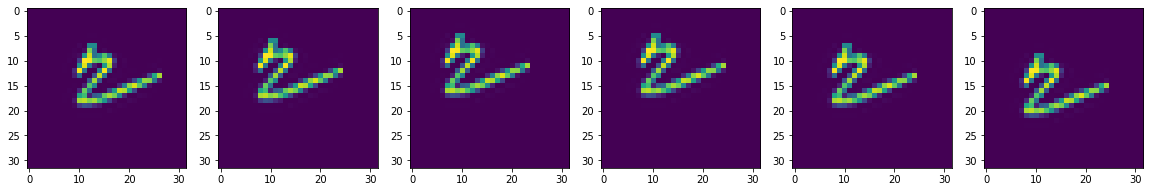

In [15]:
batch_size = 128
data_set_type = "mnist"
three_channels=False


n_frames = 6
testset = stochasticMovingMnist.MovingMNIST(False, 'Mnist', seq_len=n_frames, image_size=32, digit_size=24, num_digits=1, 
                                            deterministic=False, three_channels=three_channels, step_length=2, normalize=False)
trainset = stochasticMovingMnist.MovingMNIST(True, 'Mnist', seq_len=n_frames, image_size=32, digit_size=24, num_digits=1, 
                                              deterministic=False, three_channels=three_channels, step_length=2, normalize=False)

train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader=DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)
x_plot = next(iter(train_loader))[0].permute(0,2,3,1)

if three_channels:
  fig, ax = plt.subplots(1, n_frames, figsize = (20,5))
  for i in range(n_frames): 
    ax[i].imshow(x_plot[i])
  plt.show()
else:
  fig, ax = plt.subplots(1, n_frames, figsize = (20,5))
  for i in range(n_frames): 
    ax[i].imshow(x_plot[i].view(32,32))
  plt.show()




# Normal Glow

In [16]:
class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]
        self.register_parameter("bias", nn.Parameter(torch.zeros(*size), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.zeros(*size), requires_grad=True))
        
        # Buffer to register if initialization has been performed
        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))

    def initialize(self, input):
      if not self.training:
        return

      with torch.no_grad():
          bias = input.clone().mean(dim=[0, 2, 3], keepdim=True)
          std_input = input.clone().std(dim=[0, 2, 3], keepdim=True)
          logs = (1.0 / (std_input + 1e-6)).log()
          self.bias.data.copy_(-bias)
          self.logs.data.copy_(logs)

    def forward(self, input, logdet, reverse):
        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        dims = input.size(2) * input.size(3)

        if reverse == False:
            input = input + self.bias
            input = input * self.logs.exp()
            dlogdet = torch.sum(self.logs) * dims
            if logdet is not None:
              logdet = logdet + dlogdet

        if reverse == True:
            input = input * self.logs.mul(-1).exp()
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dims
            if logdet is not None:
              logdet = logdet + dlogdet

        return input, logdet

class Conv2dZeros(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=[3,3], stride=[1,1]):
        super().__init__()
        
        padding = (kernel_size[0] - 1) // 2
        self.conv = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride, padding=padding)
        
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()

    def forward(self, input):
      output = self.conv(input)
      return output 

class Conv2dNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=[3, 3], stride=[1, 1], norm = "actnorm"):
        super().__init__()

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=(norm != "actnorm"))
        self.conv.weight.data.normal_(mean=0.0, std=0.05)
        
        self.norm = norm
        if self.norm == "actnorm":
          self.norm_type = ActNorm(out_channels)
        elif self.norm=="batchnorm":
          self.conv.bias.data.zero_()
          self.norm_type = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        output = self.conv(input)
        if self.norm == "actnorm":
          output,_ = self.norm_type(output, logdet=0.0, reverse=False)
        elif self.norm == "batchnorm":
          output = self.norm_type(output)
        else:
          return output
        return output

class Conv2dResize(nn.Module):
    def __init__(self, in_size, out_size, kernel_size = [3,3], stride = 2, norm="actnorm", manual = False):
        super().__init__()
        #condition size = in size
        if not manual:
          stride = [in_size[1]//out_size[1], in_size[2]//out_size[2]]
          kernel_size = Conv2dResize.compute_kernel_size(in_size, out_size, stride)
        else:
          stride = stride
          kernel_size = kernel_size
        if norm == None:
          self.conv = nn.Conv2d(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride, bias = True)
          self.conv.bias.data.zero_()
        else:
          self.conv = nn.Conv2d(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride, bias = False)
        self.conv.weight.data.zero_()
        
        self.norm = norm
        if self.norm == "actnorm":
          self.norm_type = ActNorm(out_size[0])
        elif self.norm=="batchnorm":
          self.norm_type = nn.BatchNorm2d(out_size[0])

    @staticmethod
    def compute_kernel_size(in_size, out_size, stride):
        k0 = in_size[1] - (out_size[1] - 1) * stride[0]
        k1 = in_size[2] - (out_size[2] - 1) * stride[1]
        return[k0, k1]

    def forward(self, input):
      output = self.conv(input)
      if self.norm == "actnorm":
        output,_ = self.norm_type(output, logdet=0.0, reverse=False)
      elif self.norm == "batchnorm":
        output = self.norm_type(output)
      return output 

non_lin = "relu"

class ActFun(nn.Module):
  def __init__(self, non_lin, in_place = False):
    super(ActFun, self).__init__()
    if non_lin=='relu':
      self.net=nn.ReLU(inplace = in_place)
    if non_lin=='leakyrelu':
      self.net=nn.LeakyReLU(negative_slope=0.20, inplace = in_place)

  def forward(self,x):
    return self.net(x)

class InvConv(nn.Module):
    def __init__(self, num_channels, LU_decomposed):
        super().__init__()
        w_shape = [num_channels, num_channels]
        w_init = torch.qr(torch.randn(*w_shape))[0]

        if not LU_decomposed:
            self.weight = nn.Parameter(torch.Tensor(w_init))
        else:
            p, lower, upper = torch.lu_unpack(*torch.lu(w_init))
            s = torch.diag(upper)
            sign_s = torch.sign(s)
            log_s = torch.log(torch.abs(s))
            upper = torch.triu(upper, 1)
            l_mask = torch.tril(torch.ones(w_shape), -1)
            eye = torch.eye(*w_shape)

            self.register_buffer("p", p)
            self.register_buffer("sign_s", sign_s)
            self.lower = nn.Parameter(lower)
            self.log_s = nn.Parameter(log_s)
            self.upper = nn.Parameter(upper)
            self.l_mask = l_mask
            self.eye = eye

        self.w_shape = w_shape
        self.LU_decomposed = LU_decomposed

    def get_weight(self, input, reverse):
        b, c, h, w = input.shape

        if not self.LU_decomposed:
            dlogdet = torch.slogdet(self.weight)[1] * h * w
            if reverse:
                weight = torch.inverse(self.weight)
            else:
                weight = self.weight
        else:
            self.l_mask = self.l_mask.to(input.device)
            self.eye = self.eye.to(input.device)

            lower = self.lower * self.l_mask + self.eye

            u = self.upper * self.l_mask.transpose(0, 1).contiguous()
            u = u + torch.diag(self.sign_s * torch.exp(self.log_s))

            dlogdet = torch.sum(self.log_s) * h * w

            if reverse:
                u_inv = torch.inverse(u)
                l_inv = torch.inverse(lower)
                p_inv = torch.inverse(self.p)

                weight = torch.matmul(u_inv, torch.matmul(l_inv, p_inv))
            else:
                weight = torch.matmul(self.p, torch.matmul(lower, u))

        return weight.view(self.w_shape[0], self.w_shape[1], 1, 1), dlogdet

    def forward(self, input, logdet, reverse):
        weight, dlogdet = self.get_weight(input, reverse)

        if not reverse:
            z = F.conv2d(input, weight)
            if logdet is not None:
              logdet = logdet + dlogdet
            return z, logdet
        else:
            z = F.conv2d(input, weight)
            if logdet is not None:
              logdet = logdet - dlogdet
            return z, logdet

class AffineCoupling(nn.Module):
    def __init__(self, x_size, condition_size):
        super(AffineCoupling, self).__init__()
        
        Bx, Cx, Hx, Wx = x_size
        if condition_size is not None:
          B, C, H, W = condition_size
          temp = torch.zeros(condition_size)
          temp = temp.view(Bx, -1, Hx, Wx)
          channels = Cx // 2 + temp.shape[1]
        else:
          channels = Cx // 2

        hidden_channels = 128
        self.net = nn.Sequential(
            Conv2dNorm(channels, hidden_channels),
            ActFun(non_lin),
            Conv2dNorm(hidden_channels, hidden_channels, kernel_size=[1, 1]),
            ActFun(non_lin),
            Conv2dZeros(hidden_channels, Cx),
        )

        self.scale = nn.Parameter(torch.zeros(Cx//2, 1, 1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(Cx//2, 1, 1), requires_grad=True)
        
    def forward(self, x, condition, logdet, reverse): # how to match condition here for L>1
        z1, z2 = utils.split_feature(x, "split")

        if condition is not None:
          condition = condition.view(x.shape[0], -1, x.shape[2], x.shape[3])
          assert condition.shape[2:4] == x.shape[2:4], "condition and x in affine needs to match"
          h = torch.cat([z1, condition], dim=1)
        else:
          h = z1
        
        shift, log_scale = utils.split_feature(self.net(h), "cross")
        # Here we could try to use the exponential as suggested in arXiv:1907.02392v3
        log_scale = self.scale * torch.tanh(log_scale) + self.scale_shift

        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * torch.exp(log_scale)
            if logdet is not None:
              logdet = logdet + torch.sum(log_scale, dim=[1, 2, 3])
        else:
            z2 = z2 * log_scale.mul(-1).exp()
            z2 = z2 - shift
            if logdet is not None:
              logdet = logdet - torch.sum(log_scale, dim=[1, 2, 3]) 

        output = torch.cat((z1, z2), dim=1)
        return output, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size, LU_decompose):
      super(GlowStep, self).__init__()
      
      b, c, h, w = x_size
      if condition_size is not None:
        bc, cc, hc, wc = condition_size
      self.actnorm = ActNorm(c)
      self.invconv =  InvConv(c, LU_decomposed = LU_decompose)
      self.affine =  AffineCoupling(x_size, condition_size)
       
    def forward(self, x, condition, logdet, reverse):
        if reverse == False:
            x, logdet = self.actnorm(x, logdet, reverse=False)
            x, logdet = self.invconv(x, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, logdet, reverse=True)
            x, logdet = self.actnorm(x, logdet, reverse=True)
            return x, logdet


class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x


class Split2d(nn.Module):
    def __init__(self, x_size, condition_size):
      super(Split2d, self).__init__()

      Bx, Cx, Hx, Wx = x_size
      if condition_size is not None: # We should be able to remove temp when list of conds is implemented
        B, C, H, W = condition_size
        temp = torch.zeros(condition_size)
        temp = temp.view(Bx, -1, Hx, Wx)
        channels = Cx // 2 + temp.shape[1]
      else:
        channels = Cx // 2
        
      self.conv = nn.Sequential(Conv2dZeros(channels, Cx),)
      

    def forward(self, x, condition, logdet, reverse):
        if condition is not None:
          condition = condition.view(x.shape[0], -1, x.shape[2], x.shape[3])
          
        if reverse == False:
            z1, z2 = utils.split_feature(x, "split")
            if condition is not None:
              h = torch.cat([z1, condition], dim=1)
            else:
              h = z1
            out = self.conv(h)
            mean, log_scale = utils.split_feature(out, "cross")
            if logdet is not None:
              logdet = logdet + torch.sum(td.Normal(mean, torch.exp(log_scale)).log_prob(z2), dim=(1,2,3))
            return z1, logdet
        else:
            if condition is not None:
              h = torch.cat([x, condition], dim=1)
            else:
              h = x
            mean, log_scale = utils.split_feature(self.conv(h), "cross")
            z2 = td.Normal(mean, torch.exp(log_scale)).rsample()
            z = torch.cat((x, z2), dim=1)
            return z, logdet

class Glow(nn.Module):
    def __init__(self, x_size, condition_size = None, K = 12, L = 2, learn_prior = True, LU_decompose = True):
        super(Glow, self).__init__()

        self.L = L
        self.K = K
        Bx, Cx, Hx, Wx = x_size
        if condition_size is not None:
          Bc, Cc, Hc, Wc = condition_size
        layers = []

        for l in range(0, L):
            layers.append(Squeeze2d())
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [Bx, Cx, Hx, Wx]
            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size, LU_decompose))
            
            if l < (L-1):
                layers.append(Split2d(x_size, condition_size)) 
                Cx = Cx // 2 
                x_size = [Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if learn_prior == True:
          if condition_size is not None:
            self.prior = nn.Sequential(
                Conv2dResize((Cc, Hc, Wc), out_size=(64, Hx*2, Wx*2), norm=None),
                ActFun(non_lin),
                Conv2dResize((64, Hx*2, Wx*2), out_size=(32, Hx, Wx), norm=None),
                ActFun(non_lin),
                Conv2dZeros(in_channel=32, out_channel=2*Cx)
                )
          else:
            self.prior_in = torch.zeros([1, Cx, Hx, Wx,]).to(device)
            self.prior = Conv2dZeros(in_channel=Cx, out_channel=2*Cx)
        else:
          self.prior_in = torch.zeros([1, 2*Cx, Hx, Wx,]).to(device)
          

    def g(self, z, condition, logdet):
        # maps z -> x
        x = z
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            x, logdet = step(x, condition, logdet = logdet, reverse=True)
          else:
            x, logdet = step(x, condition, logdet = logdet, reverse=True)
        return x, logdet

    def f(self, x, condition, logdet):
        # maps x -> z
        z = x
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z, undo_squeeze=False)
            elif isinstance(step, Split2d):
                z, logdet = step(z, condition, logdet = logdet, reverse=False)
            else:
                z, logdet = step(z, condition, logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition=None, logdet = None):
        dims = torch.prod(torch.tensor(x.shape[1:]))
        z, obj = self.f(x, condition, logdet)
        
        if condition is not None:
          z_in = condition
        else:
          z_in = self.prior_in.repeat(x.shape[0],1,1,1)

        if self.learn_prior:
          mean, log_scale = utils.split_feature(self.prior(z_in), type="split")
        else:
          mean, log_scale = utils.split_feature(self.prior_in.repeat(x.shape[0],1,1,1), type="split")
          
        prior = td.Normal(mean, torch.exp(log_scale))
        obj = obj + torch.sum(prior.log_prob(z), dim=(1,2,3)) #p_z
        obj = torch.mean(obj)
        nll = (-obj) / float(np.log(2.) * dims)
        return z, nll

    def sample(self, z, condition=None, num_samples = 32, temperature=0.8):
    
        with torch.no_grad():
          if z == None:

            if condition is not None:
              z_in = condition
            else:
              z_in = self.prior_in.repeat(num_samples,1,1,1)

            if self.learn_prior:
              mean, log_scale = utils.split_feature(self.prior(z_in), type="split")
            else:
              mean, log_scale = utils.split_feature(self.prior_in.repeat(num_samples,1,1,1), type="split")

            prior = td.Normal(mean, torch.exp(log_scale)*temperature)
            z = prior.sample().to(device)
          x, _ = self.g(z, condition, logdet=None)
        return x
    


# Glow with list condition

In [17]:
class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]
        self.register_parameter("bias", nn.Parameter(torch.zeros(*size), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.zeros(*size), requires_grad=True))
        
        # Buffer to register if initialization has been performed
        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))

    def initialize(self, input):
      if not self.training:
        return

      with torch.no_grad():
          bias = input.clone().mean(dim=[0, 2, 3], keepdim=True)
          std_input = input.clone().std(dim=[0, 2, 3], keepdim=True)
          logs = (1.0 / (std_input + 1e-6)).log()
          self.bias.data.copy_(-bias)
          self.logs.data.copy_(logs)

    def forward(self, input, logdet, reverse):
        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        dims = input.size(2) * input.size(3)

        if reverse == False:
            input = input + self.bias
            input = input * self.logs.exp()
            dlogdet = torch.sum(self.logs) * dims
            if logdet is not None:
              logdet = logdet + dlogdet

        if reverse == True:
            input = input * self.logs.mul(-1).exp()
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dims
            if logdet is not None:
              logdet = logdet + dlogdet

        return input, logdet

class Conv2dZeros(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=[3,3], stride=[1,1]):
        super().__init__()
        
        padding = (kernel_size[0] - 1) // 2
        self.conv = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride, padding=padding)
        
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()

    def forward(self, input):
      output = self.conv(input)
      return output 

class Conv2dNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=[3, 3], stride=[1, 1], norm = "actnorm"):
        super().__init__()

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=(norm != "actnorm"))
        self.conv.weight.data.normal_(mean=0.0, std=0.05)
        
        self.norm = norm
        if self.norm == "actnorm":
          self.norm_type = ActNorm(out_channels)
        elif self.norm=="batchnorm":
          self.conv.bias.data.zero_()
          self.norm_type = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        output = self.conv(input)
        if self.norm == "actnorm":
          output,_ = self.norm_type(output, logdet=0.0, reverse=False)
        elif self.norm == "batchnorm":
          output = self.norm_type(output)
        else:
          return output
        return output

class Conv2dResize(nn.Module):
    def __init__(self, in_size, out_size, kernel_size = [3,3], stride = 2, norm="actnorm", manual = False):
        super().__init__()
        if not manual:
          stride = [in_size[1]//out_size[1], in_size[2]//out_size[2]]
          kernel_size = Conv2dResize.compute_kernel_size(in_size, out_size, stride)
        else:
          stride = stride
          kernel_size = kernel_size
        if norm == None:
          self.conv = nn.Conv2d(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride, bias = True)
          self.conv.bias.data.zero_()
        else:
          self.conv = nn.Conv2d(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride, bias = False)
        self.conv.weight.data.zero_()
        
        self.norm = norm
        if self.norm == "actnorm":
          self.norm_type = ActNorm(out_size[0])
        elif self.norm=="batchnorm":
          self.norm_type = nn.BatchNorm2d(out_size[0])

    @staticmethod
    def compute_kernel_size(in_size, out_size, stride):
        k0 = in_size[1] - (out_size[1] - 1) * stride[0]
        k1 = in_size[2] - (out_size[2] - 1) * stride[1]
        return[k0, k1]

    def forward(self, input):
      output = self.conv(input)
      if self.norm == "actnorm":
        output,_ = self.norm_type(output, logdet=0.0, reverse=False)
      elif self.norm == "batchnorm":
        output = self.norm_type(output)
      return output 

non_lin = "relu"

class ActFun(nn.Module):
  def __init__(self, non_lin, in_place = False):
    super(ActFun, self).__init__()
    if non_lin=='relu':
      self.net=nn.ReLU(inplace = in_place)
    if non_lin=='leakyrelu':
      self.net=nn.LeakyReLU(negative_slope=0.20, inplace = in_place)

  def forward(self,x):
    return self.net(x)

class InvConv(nn.Module):
    def __init__(self, num_channels, LU_decomposed):
        super().__init__()
        w_shape = [num_channels, num_channels]
        w_init = torch.qr(torch.randn(*w_shape))[0]

        if not LU_decomposed:
            self.weight = nn.Parameter(torch.Tensor(w_init))
        else:
            p, lower, upper = torch.lu_unpack(*torch.lu(w_init))
            s = torch.diag(upper)
            sign_s = torch.sign(s)
            log_s = torch.log(torch.abs(s))
            upper = torch.triu(upper, 1)
            l_mask = torch.tril(torch.ones(w_shape), -1)
            eye = torch.eye(*w_shape)

            self.register_buffer("p", p)
            self.register_buffer("sign_s", sign_s)
            self.lower = nn.Parameter(lower)
            self.log_s = nn.Parameter(log_s)
            self.upper = nn.Parameter(upper)
            self.l_mask = l_mask
            self.eye = eye

        self.w_shape = w_shape
        self.LU_decomposed = LU_decomposed

    def get_weight(self, input, reverse):
        b, c, h, w = input.shape

        if not self.LU_decomposed:
            dlogdet = torch.slogdet(self.weight)[1] * h * w
            if reverse:
                weight = torch.inverse(self.weight)
            else:
                weight = self.weight
        else:
            self.l_mask = self.l_mask.to(input.device)
            self.eye = self.eye.to(input.device)

            lower = self.lower * self.l_mask + self.eye

            u = self.upper * self.l_mask.transpose(0, 1).contiguous()
            u = u + torch.diag(self.sign_s * torch.exp(self.log_s))

            dlogdet = torch.sum(self.log_s) * h * w

            if reverse:
                u_inv = torch.inverse(u)
                l_inv = torch.inverse(lower)
                p_inv = torch.inverse(self.p)

                weight = torch.matmul(u_inv, torch.matmul(l_inv, p_inv))
            else:
                weight = torch.matmul(self.p, torch.matmul(lower, u))

        return weight.view(self.w_shape[0], self.w_shape[1], 1, 1), dlogdet

    def forward(self, input, logdet, reverse):
        weight, dlogdet = self.get_weight(input, reverse)

        if not reverse:
            z = F.conv2d(input, weight)
            if logdet is not None:
              logdet = logdet + dlogdet
            return z, logdet
        else:
            z = F.conv2d(input, weight)
            if logdet is not None:
              logdet = logdet - dlogdet
            return z, logdet

class AffineCoupling(nn.Module):
    def __init__(self, x_size, condition_size):
        super(AffineCoupling, self).__init__()
        
        Bx, Cx, Hx, Wx = x_size
        
        B, C, H, W = condition_size
        channels = Cx // 2 + C

        hidden_channels = 128
        self.net = nn.Sequential(
            Conv2dNorm(channels, hidden_channels),
            ActFun(non_lin),
            Conv2dNorm(hidden_channels, hidden_channels, kernel_size=[1, 1]),
            ActFun(non_lin),
            Conv2dZeros(hidden_channels, Cx),
        )

        self.scale = nn.Parameter(torch.zeros(Cx//2, 1, 1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(Cx//2, 1, 1), requires_grad=True)
        
    def forward(self, x, condition, logdet, reverse): 
        z1, z2 = utils.split_feature(x, "split")

        assert condition.shape[2:4] == x.shape[2:4], "condition and x in affine needs to match"
        h = torch.cat([z1, condition], dim=1)

        shift, log_scale = utils.split_feature(self.net(h), "cross")

        # Here we could try to use the exponential as suggested in arXiv:1907.02392v3
        log_scale = self.scale * torch.tanh(log_scale) + self.scale_shift

        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * torch.exp(log_scale)
            if logdet is not None:
              logdet = logdet + torch.sum(log_scale, dim=[1, 2, 3])
        else:
            z2 = z2 * log_scale.mul(-1).exp()
            z2 = z2 - shift
            if logdet is not None:
              logdet = logdet - torch.sum(log_scale, dim=[1, 2, 3]) 

        output = torch.cat((z1, z2), dim=1)
        return output, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size, LU_decompose):
      super(GlowStep, self).__init__()
      
      b, c, h, w = x_size
      bc, cc, hc, wc = condition_size
      self.actnorm = ActNorm(c)
      self.invconv =  InvConv(c, LU_decomposed = LU_decompose)
      self.affine =  AffineCoupling(x_size, condition_size)
       
    def forward(self, x, condition, logdet, reverse):
        if reverse == False:
            x, logdet = self.actnorm(x, logdet, reverse=False)
            x, logdet = self.invconv(x, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, logdet, reverse=True)
            x, logdet = self.actnorm(x, logdet, reverse=True)
            return x, logdet


class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x

class Split2d(nn.Module):
    def __init__(self, x_size, condition_size):
      super(Split2d, self).__init__()

      Bx, Cx, Hx, Wx = x_size
      B, C, H, W = condition_size
      channels = Cx // 2 + C 
        
      self.conv = nn.Sequential(Conv2dZeros(channels, Cx),)

    # TODO: We could try to use the Convnorm here, make more powerful (maybe)
    # TODO: Make option to enable conditional.
    def forward(self, x, condition, logdet, reverse):

        if reverse == False:
            z1, z2 = utils.split_feature(x, "split")
            h = torch.cat([z1, condition], dim=1)
            out = self.conv(h)
            mean, log_scale = utils.split_feature(out, "cross")
            if logdet is not None:
              logdet = logdet + torch.sum(td.Normal(mean, torch.exp(log_scale)).log_prob(z2), dim=(1,2,3))
            return z1, logdet
        else:
            h = torch.cat([x, condition], dim=1)
            mean, log_scale = utils.split_feature(self.conv(h), "cross")
            z2 = td.Normal(mean, torch.exp(log_scale)).rsample()
            z = torch.cat((x, z2), dim=1)
            return z, logdet

class ListGlow(nn.Module):
    def __init__(self, x_size, condition_size, base_dist_size, K = 12, L = 2, learn_prior = True, LU_decompose = True):
        super(ListGlow, self).__init__()
        
        assert isinstance(condition_size, list), "condition_size is not a list, make sure it fits L"

        self.L = L
        self.K = K
        Bx, Cx, Hx, Wx = x_size
        Bc, Cc, Hc, Wc = base_dist_size
        layers = []
        
        for l in range(0, L):
            layers.append(Squeeze2d())
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [Bx, Cx, Hx, Wx]
            
            condition_size_cur = condition_size[l]

            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size_cur, LU_decompose))
            
            if l < (L-1):
                layers.append(Split2d(x_size, condition_size_cur)) 
                Cx = Cx // 2 
                x_size = [Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if learn_prior == True:
          # TODO: We could try to use the Convnorm here, make more powerful (maybe)
          self.prior = nn.Sequential(
            Conv2dNorm(Cc, Cc//2),
            ActFun("leakyrelu"),
            Conv2dNorm(Cc//2, Cc//4),
            ActFun("leakyrelu"),
            Conv2dZeros(in_channel=Cc//4, out_channel=2*Cx),
            )
        else:
          self.prior_in = torch.zeros([1, 2*Cx, Hx, Wx,]).to(device)
          

    def g(self, z, condition, logdet):
        # maps z -> x
        x = z
        l = len(condition)-1
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            l = l-1
            x, logdet = step(x, condition[l], logdet = logdet, reverse=True)
          else:
            x, logdet = step(x, condition[l], logdet = logdet, reverse=True)
        return x, logdet


    def f(self, x, condition, logdet):
        # maps x -> z
        z = x
        l=0
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z, undo_squeeze=False)
            elif isinstance(step, Split2d):
                z, logdet = step(z, condition[l], logdet = logdet, reverse=False)
                l = l+1
            else:
                z, logdet = step(z, condition[l], logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition, base_condition, logdet = None):
        
        assert isinstance(condition, list), "Condition is not a list, make sure it fits L"
        dims = torch.prod(torch.tensor(x.shape[1:]))
        z, obj = self.f(x, condition, logdet)
        
        z_in = base_condition

        if self.learn_prior:
          mean, log_scale = utils.split_feature(self.prior(z_in), type="split")
        else:
          mean, log_scale = utils.split_feature(self.prior_in.repeat(x.shape[0],1,1,1), type="split")
          
        prior = td.Normal(mean, torch.exp(log_scale))
        obj = obj + torch.sum(prior.log_prob(z), dim=(1,2,3)) #p_z
        obj = torch.mean(obj)
        nll = (-obj) / float(np.log(2.) * dims)
        return z, nll

    def sample(self, z, condition, base_condition, num_samples = 32, temperature=0.8):
    
        with torch.no_grad():
          if z == None:

            z_in = base_condition
            if self.learn_prior:
              mean, log_scale = utils.split_feature(self.prior(z_in), type="split")
            else:
              mean, log_scale = utils.split_feature(self.prior_in.repeat(num_samples,1,1,1), type="split")

            prior = td.Normal(mean, torch.exp(log_scale)*temperature)
            z = prior.sample().to(device)
          x, _ = self.g(z, condition, logdet=None)
        return x

# ConvLSTM

In [18]:

class ConvLSTMLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, bias, dropout = 0, peephole=True, norm = False):
        super(ConvLSTMLayer, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size 
        self.peephole = peephole
        self.padding = ((kernel_size[0] - 1) // 2, (kernel_size[1] - 1) // 2)
        self.bias = bias
        layers = []

        layers.append(nn.Conv2d(in_channels = self.in_channels + self.hidden_channels,
                              out_channels = 4 * self.hidden_channels,
                              kernel_size = self.kernel_size,
                              stride = 1,
                              padding = self.padding,
                              bias = self.bias))

        if norm == True:
          # TODO: Groupnorm might not work, specify groups.
          layers.append(nn.GroupNorm(4 * self.hidden_channels // 32, 4 * self.hidden_channels))
        if dropout != 0:
          layers.append(nn.Dropout2d(p = dropout))

        self.conv = nn.Sequential(*layers)

        self.init_done = False
        self.apply(self.initialize_weights)

    def forward(self, input_tensor, cur_state):
        b, c, h, w = input_tensor.shape
        if cur_state[0] == None:
          h_cur = nn.Parameter(torch.zeros(b, self.hidden_channels, h, w)).to(device)
          c_cur = nn.Parameter(torch.zeros(b, self.hidden_channels, h, w)).to(device)
        else:
          h_cur, c_cur = cur_state

        if self.init_done == False:
          self.initialize_peephole(h, w)
          self.init_done = True

        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i + self.Wci * c_cur)
        f = torch.sigmoid(cc_f + self.Wcf * c_cur)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        o = torch.sigmoid(cc_o + self.Wco*c_next)
        h_next = o * torch.tanh(c_next)
        return h_next, c_next
    

    def initialize_weights(self, layer):
      if type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)
        nn.init.uniform_(layer.bias)
    
    def initialize_peephole(self, height, width):
      if self.peephole:
        self.Wci = nn.Parameter(torch.zeros(1, self.hidden_channels, height, width)).to(device)
        self.Wcf = nn.Parameter(torch.zeros(1, self.hidden_channels, height, width)).to(device)
        self.Wco = nn.Parameter(torch.zeros(1, self.hidden_channels, height, width)).to(device)
      else:
        self.Wci = 0
        self.Wcf = 0
        self.Wco = 0
        
class ConvLSTM(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, bias=True, dropout = 0, peephole=True, norm = False):
        super(ConvLSTM, self).__init__()
        self.hidden_channels = hidden_channels
        self.LSTMlayer = ConvLSTMLayer(in_channels=in_channels,
                                          hidden_channels=hidden_channels,
                                          kernel_size=kernel_size,
                                          bias=bias, dropout=dropout, peephole = peephole,
                                          norm = norm)
    
    def forward(self, x, ht=None, ct=None):
        b, seq_len, channel, h, w = x.size()
        output = []

        for t in range(seq_len):
            ht, ct = self.LSTMlayer(input_tensor=x[:, t, :, :, :],
                                              cur_state=[ht, ct])
            output.append(ht)
        return torch.stack(output,1), ht, ct

# RFN Nets

In [19]:
class ActFun(nn.Module):
  def __init__(self, non_lin, in_place = False):
    super(ActFun, self).__init__()
    if non_lin=='relu':
      self.net=nn.ReLU(inplace = in_place)
    if non_lin=='leakyrelu':
      self.net=nn.LeakyReLU(negative_slope=0.20, inplace = in_place)

  def forward(self,x):
    return self.net(x)

class NoNorm(nn.Module):
    def __init__(self):
      super(NoNorm, self).__init__()
    
    def forward(self, x):
      return x

class NormLayer(nn.Module):
    def __init__(self, in_channels, norm_type):
      super(NormLayer, self).__init__()
      if norm_type =='batchnorm':
        self.norm = nn.BatchNorm2d(in_channels)
      elif norm_type =='instancenorm':
        self.norm = nn.InstanceNorm2d(in_channels)
      elif norm_type =='none':
        self.norm = NoNorm()
      else:
        assert False, 'Please specify a norm type from the set {batchnorm, instancenorm, none}'
    
    def forward(self, x):
      return self.norm(x)


class VGG_downscaler(nn.Module):
  def __init__(self, structure, in_channels = 1, norm_type = "batchnorm", non_lin = "leakyrelu", scale=2):
    super(VGG_downscaler, self).__init__()

    layers = []
    for i in structure:
        if i == 'pool':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif i == "conv":
            conv_channels = int(in_channels*scale)
            conv2d = nn.Conv2d(in_channels, conv_channels, kernel_size=3, stride = 2, padding=1)
            layers += [conv2d,
                       NormLayer(conv_channels, norm_type = norm_type), 
                       ActFun(non_lin, in_place=True)]
            in_channels = conv_channels
        else:
            conv2d = nn.Conv2d(in_channels, i, kernel_size=3, padding=1)
            layers += [conv2d, NormLayer(i, norm_type = norm_type), ActFun(non_lin, in_place=True)]
            in_channels = i
    
    self.net = nn.Sequential(*layers)

  def forward(self, x):
    return self.net(x)


class VGG_upscaler(nn.Module):
  def __init__(self, structures, L, in_channels, norm_type = "batchnorm", non_lin = "relu", scale = 2):
    super(VGG_upscaler, self).__init__()
    assert len(structures) == L, "Please specify number of blocks = L"
    self.l_nets = []
    self.L = L

    for l in range(0, L):
      structure = structures[l]
      layers = []
      for i in structure:
          if i == 'upsample':
              layers += [nn.Upsample(scale_factor=2, mode='nearest')]
          elif i == "deconv":
              deconv_channels = in_channels // scale
              deconv = nn.ConvTranspose2d(in_channels, deconv_channels, kernel_size=4, stride = 2, padding=1, bias=False)
              layers += [deconv, 
                        NormLayer(deconv_channels, norm_type = norm_type),
                        ActFun(non_lin, in_place=True)]
              in_channels = deconv_channels
          else:
              conv2d = nn.Conv2d(in_channels, i, kernel_size=3, stride=1, padding=1)
              layers += [conv2d,  NormLayer(i, norm_type = norm_type), ActFun(non_lin, in_place=True)]
              in_channels = i
      
          self.net = nn.Sequential(*layers).to(device)
          # for m in self.modules():
          #   if isinstance(m, nn.Conv2d):
          #       m.weight.data.normal_(0, 0.05)
          #       m.bias.data.zero_()
          #   elif isinstance(m, nn.ConvTranspose2d):
          #       m.weight.data.normal_(0, 0.05)

      self.l_nets.append(self.net)

  def forward(self, x, block_size=None):
    outputs = []
    for i in range(0, self.L):
      x = self.l_nets[i](x)
      outputs.append(x)
    outputs.reverse()
    return outputs

class SimpleParamNet(nn.Module):
  def __init__(self, structure, in_channels, out_channels, norm_type = "batchnorm", non_lin = "leakyrelu", scale = 2):
    super(SimpleParamNet, self).__init__()

    layers = []
    for i in structure:
        if i == 'pool':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif i == "conv":
            conv_channels = int(scale*in_channels)
            conv2d = nn.Conv2d(in_channels, conv_channels, kernel_size=3, stride = 2, padding=1)
            layers += [conv2d,
                       NormLayer(conv_channels, norm_type = norm_type), 
                       ActFun(non_lin, in_place=True)]
            in_channels = conv_channels
        else:
            conv2d = nn.Conv2d(in_channels, i, kernel_size=3, padding=1)
            layers += [conv2d, NormLayer(i, norm_type = norm_type), ActFun(non_lin, in_place=True)]
            in_channels = i
    
    self.net = nn.Sequential(*layers)
    self.loc = nn.Conv2d(in_channels, out_channels,  kernel_size=3, stride=1, padding=1)
    self.scale = nn.Sequential(nn.Conv2d(in_channels, out_channels,  kernel_size=3, stride=1, padding=1), nn.Softplus())
    
  def forward(self, x):
    output = self.net(x)
    loc = self.loc(output)
    scale = self.scale(output)
    return loc, scale


In [20]:

class RFN(nn.Module):
    def __init__(self):
      super(RFN, self).__init__()

      self.batch_size = batch_size
      self.u_dim = (batch_size, 1, 32, 32)
      self.x_dim = (batch_size, 1, 32, 32)
      self.h_dim = 100
      self.z_dim = 30
      self.beta = 1
      scaler = 1 # Chooses the scaling of 'conv' and 'deconv' layers, default is 2
      self.L = 4
      self.K = 8
      norm_type = "none"
      context_dim = 128 # Channel output of feature extractor
      condition_size_list = []
      
      # Tip: Use 2 convs between each pool and only 1 conv between each strided conv
      # Each 'conv' will multiply channels by 2 and each deconv will divide by 2.
      down_structure = [32, 'conv', 32, 'conv', 64, 'conv', 64, 'conv',  context_dim]
      up_structure = [[128], ['deconv', 64], ['deconv', 64], ['deconv', 32]]
      
      # adjust channel dims to match up_structure. Reversed.
      channel_dims = [32, 64, 64, 128]
      hu, wu = (self.u_dim[2], self.u_dim[3])
      for i in range(0, self.L):
        hu, wu = (hu//2, hu//2)
        condition_size_list.append([batch_size, channel_dims[i], hu, wu])
      
      self.h_0 = nn.Parameter(torch.zeros(batch_size, self.h_dim, hu, wu))
      self.c_0 = nn.Parameter(torch.zeros(batch_size, self.h_dim, hu, wu))
      
      # TODO: Maybe adjust to take the output from extractor [:, :, 1, 1] and only use this, then upscale for glow
      self.z_0 = nn.Parameter(torch.zeros(batch_size, self.z_dim, hu, wu))
      self.z_0x = nn.Parameter(torch.zeros(batch_size, self.z_dim, hu, wu))

      # Feature extractor and upscaler for flow
      self.extractor = VGG_downscaler(down_structure, in_channels = self.x_dim[1], 
                                      norm_type = norm_type, non_lin = "leakyrelu", scale = scaler)
      self.upscaler = VGG_upscaler(up_structure, L=self.L, in_channels = self.h_dim + self.z_dim, 
                                   norm_type = norm_type, non_lin = "relu", scale = scaler)

      # ConvLSTM
      self.lstm = ConvLSTM(in_channels = context_dim, hidden_channels=self.h_dim, 
                           kernel_size=[3, 3], bias=True, peephole=True)

      # Prior
      prior_struct = [128]
      self.prior = SimpleParamNet(prior_struct, in_channels = self.h_dim + self.z_dim, 
                                  out_channels = self.z_dim, norm_type = norm_type, non_lin = "leakyrelu")
      
      # Flow
      base_dim = (batch_size, self.h_dim + self.z_dim, hu, wu)
      self.flow = ListGlow(self.x_dim, condition_size_list, base_dim, K=self.K, L=self.L, 
                           learn_prior = True)

      # Variational encoder
      enc_struct = [256, 128]
      self.encoder = SimpleParamNet(enc_struct, in_channels = context_dim + self.h_dim + self.z_dim, 
                                    out_channels = self.z_dim, norm_type = norm_type, non_lin = "leakyrelu")
      
      # Bookkeeping
      self.book = {"zt": 0, "b": 0, "enc_loc": 0, "ht": 0, "kl": 0, "nll": 0}
    
    def get_inits(self):
      loss = 0
      kl_loss = 0
      nll_loss = 0
      return self.h_0, self.c_0, self.z_0, self.z_0x, loss, kl_loss, nll_loss

    def loss(self, x, logdet):
      assert len(x.shape) == 5, "x must be [bs, t, c, h, w]"
      hprev, cprev, zprev, zxprev, loss, kl_loss, nll_loss = self.get_inits()
      t = x.shape[1]

      features = []
      for i in range(0, t):
        features.append(self.extractor(x[:, i, :, :, :]))
      
      for i in range(1, t):
        condition = features[i-1]
        x_feature = features[i]

        _, ht, ct = self.lstm(condition.unsqueeze(1), hprev, cprev) 
        # TODO: maybe try to make another LSTM but only for the prior.

        prior_mean, prior_std = self.prior(torch.cat((ht, zprev), dim=1))
        dist_prior = td.Normal(prior_mean, prior_std)
        zt = dist_prior.rsample()

        # Try to flatten zt?
        enc_mean, enc_std = self.encoder(torch.cat((ht, zxprev, x_feature), dim = 1))
        dist_enc = td.Normal(enc_mean, enc_std)
        zxt = dist_enc.rsample()
        
        # Maybe try to split so base conditions and flow conditions have their own input seperately.
        flow_conditions = self.upscaler(torch.cat((zxt, ht), dim = 1))
        base_conditions = torch.cat((zxt, ht), dim = 1)
        
        b, nll = self.flow.log_prob(x[:, i, :, :, :], flow_conditions, base_conditions, logdet)
        
        # TODO: Probably shouldn't divide by dims_z
        dims_z = torch.prod(torch.tensor(zt.shape[1:]))
        kl_loss = kl_loss + td.kl_divergence(dist_enc, dist_prior).sum([1,2,3]).mean() / dims_z
        nll_loss = nll_loss + nll 

        hprev, cprev, zprev, zxprev = ht, ct, zt, zxt
      
      self.book["zt"] = zt.detach()
      self.book["b"] = b.detach()
      self.book["enc_loc"] = enc_mean.detach()
      self.book["ht"] = ht.detach()
      self.book["kl"] = kl_loss.detach()
      self.book["nll"] = nll_loss.detach()

      loss = (self.beta * kl_loss) + nll_loss
      return loss

    def sample(self, x, n_predictions=6, temperature = 0.8, encoder_sample = False):
      assert len(x.shape) == 5, "x must be [bs, t, c, h, w]"
      hprev, cprev, zprev, zxprev, _, _, _ = self.get_inits()
      t = x.shape[1]

      samples = torch.zeros((t-1, *x[:,0,:,:,:].shape))
      samples_recon = torch.zeros((t-1, *x[:,0,:,:,:].shape))

      features = []
      for i in range(0, t):
        features.append(self.extractor(x[:, i, :, :, :]))
      
      for i in range(1, t):
        condition = features[i-1]
        x_feature = features[i]
        
        _, ht, ct = self.lstm(condition.unsqueeze(1), hprev, cprev)

        enc_mean, enc_std = self.encoder(torch.cat((zxprev, ht, x_feature), dim = 1))
        dist_enc = td.Normal(enc_mean, enc_std)
        zxt = dist_enc.rsample()

        prior_mean, prior_std = self.prior(torch.cat((ht, zprev), dim=1))
        dist_prior = td.Normal(prior_mean, prior_std)
        zt = dist_prior.rsample()

        if encoder_sample:
          flow_conditions = self.upscaler(torch.cat((zxt, ht), dim = 1))
          base_conditions = torch.cat((zxt, ht), dim = 1)
          zxprev = zxt
        else:
          flow_conditions = self.upscaler(torch.cat((zt, ht), dim = 1))
          base_conditions = torch.cat((zt, ht), dim = 1)
          zprev = zt
        
        sample = self.flow.sample(None, flow_conditions, base_conditions, temperature)
        z, _ = self.flow.log_prob(x[:, i, :, :, :], flow_conditions, base_conditions, 0.0)
        sample_recon = self.flow.sample(z, flow_conditions, base_conditions, temperature)
        
        hprev, cprev = ht, ct

        samples[i-1,:,:,:,:] = sample.detach()
        samples_recon[i-1,:,:,:,:] = sample_recon.detach()
      
      # Make predictions
      predictions = torch.zeros((n_predictions, *x[:,0,:,:,:].shape))
      for i in range(0, n_predictions):
        condition = self.extractor(sample)
        _, ht, ct = self.lstm(condition.unsqueeze(1), hprev, cprev)
        prior_mean, prior_std = self.prior(torch.cat((ht, zprev), dim=1))
        dist_prior = td.Normal(prior_mean, prior_std)
        zt = dist_prior.rsample()

        flow_conditions = self.upscaler(torch.cat((zt, ht), dim = 1))
        base_conditions = torch.cat((zt, ht), dim = 1)
        prediction = self.flow.sample(None, flow_conditions, base_conditions, temperature)
        predictions[i-1,:,:,:,:] = prediction.detach()

        hprev, cprev, zprev, zxprev = ht, ct, zt, zxt
      return samples, samples_recon, predictions


# Train

kl: tensor(0.0196, device='cuda:0') and tensor(24.2274, device='cuda:0')


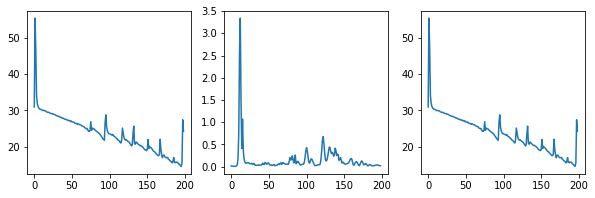

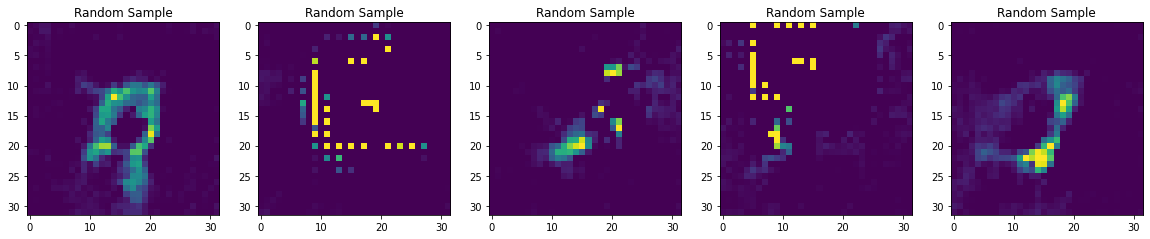

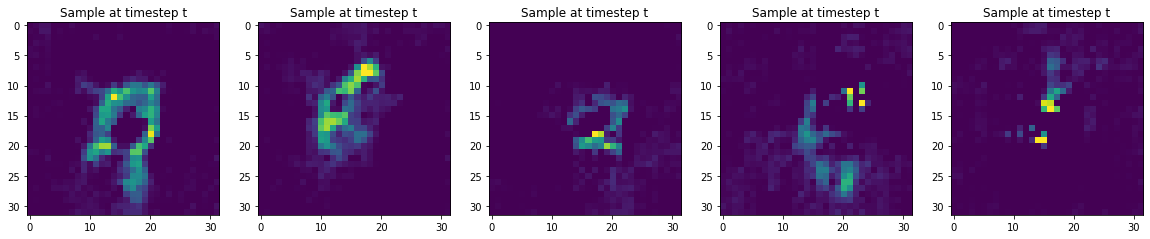

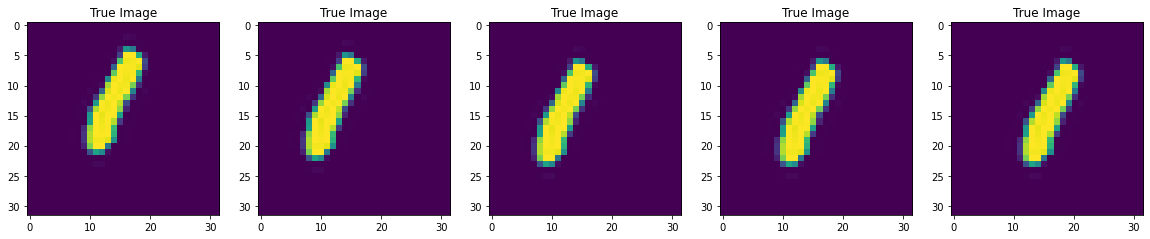

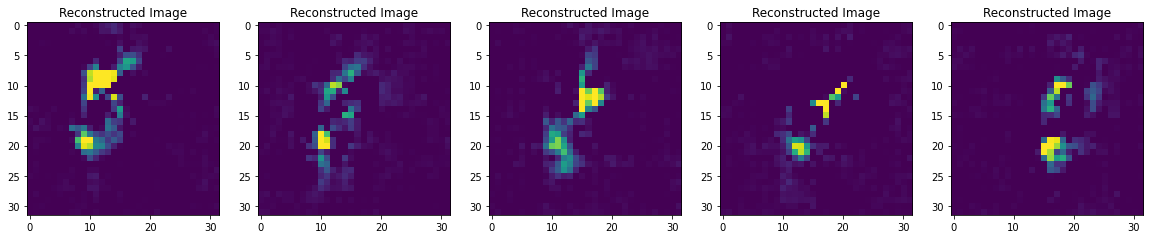

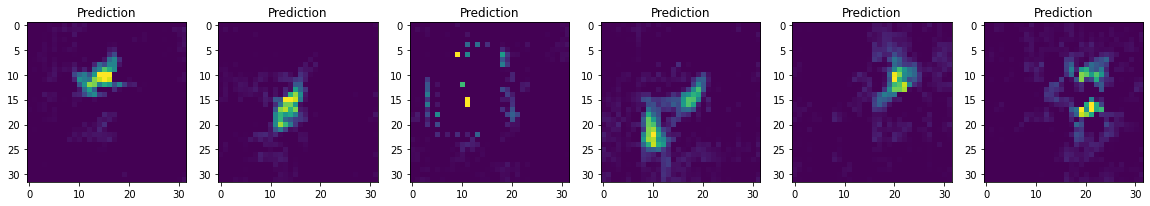

kl: tensor(0.0394, device='cuda:0') and tensor(9.4899, device='cuda:0')


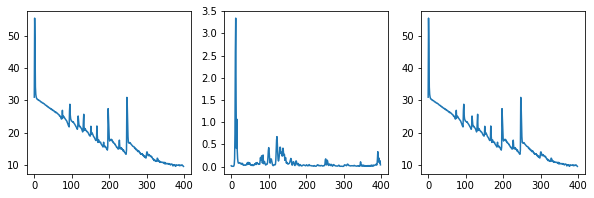

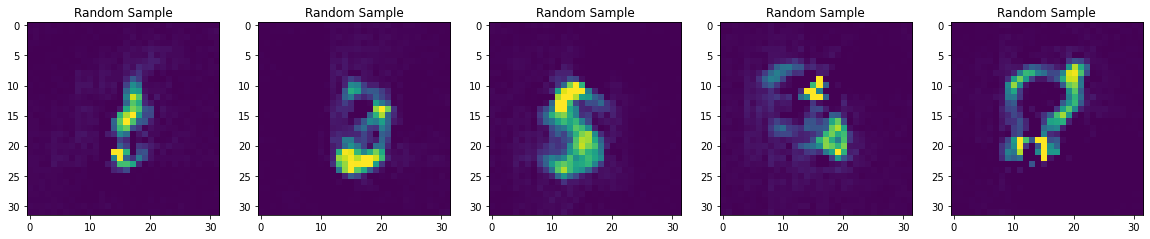

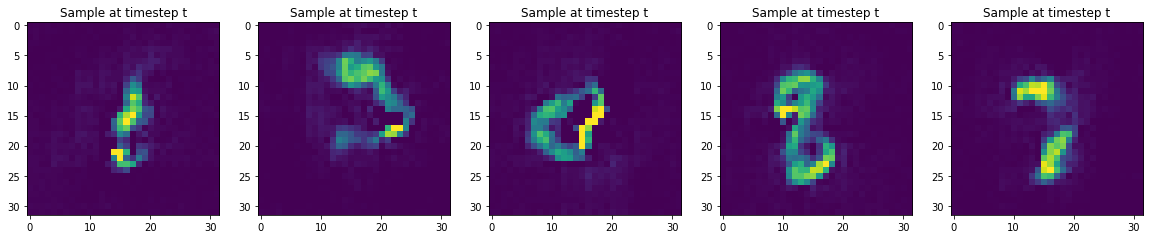

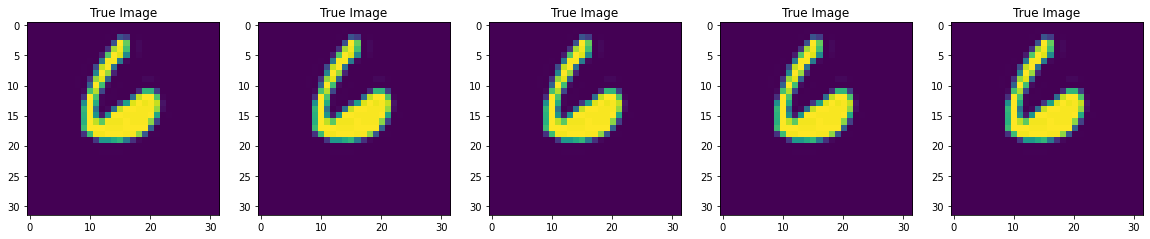

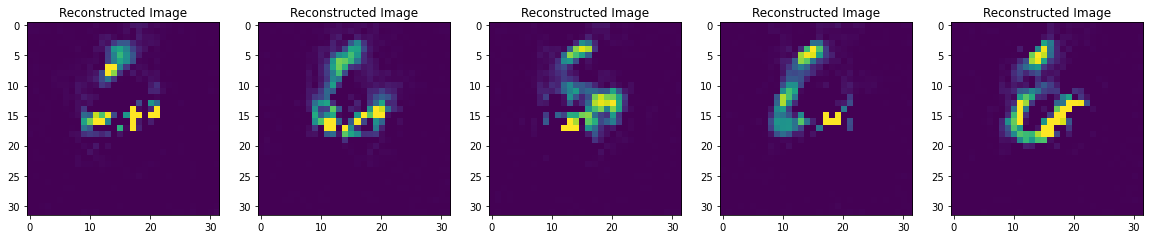

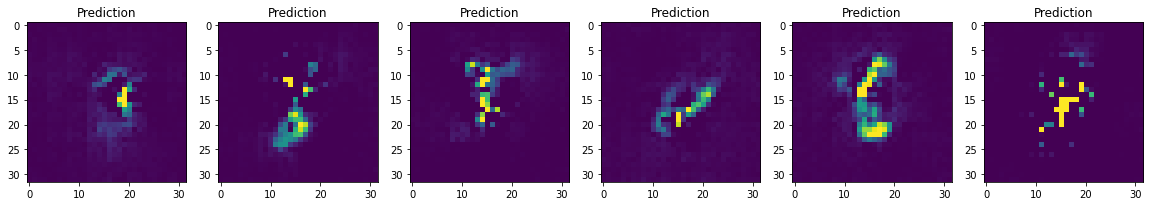

Epoch 1 Loss: 17.05


kl: tensor(0.2616, device='cuda:0') and tensor(7.6176, device='cuda:0')


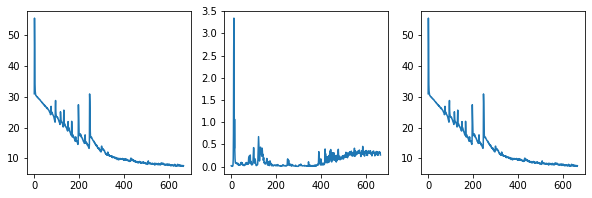

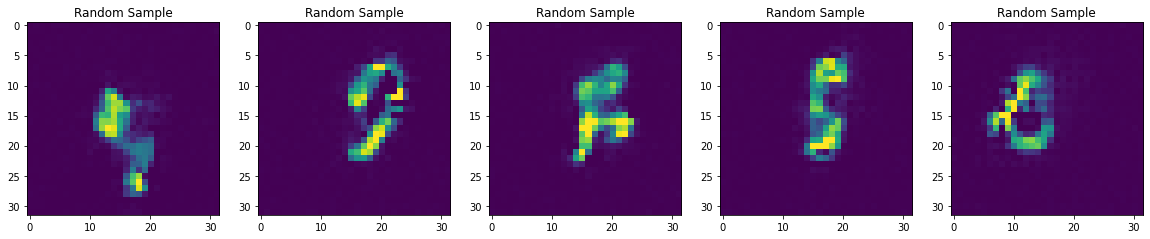

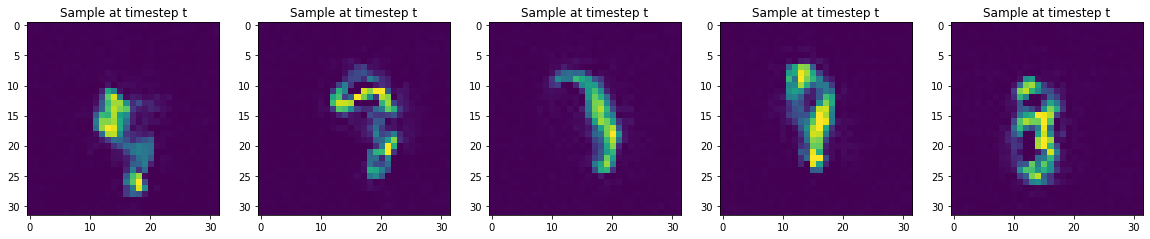

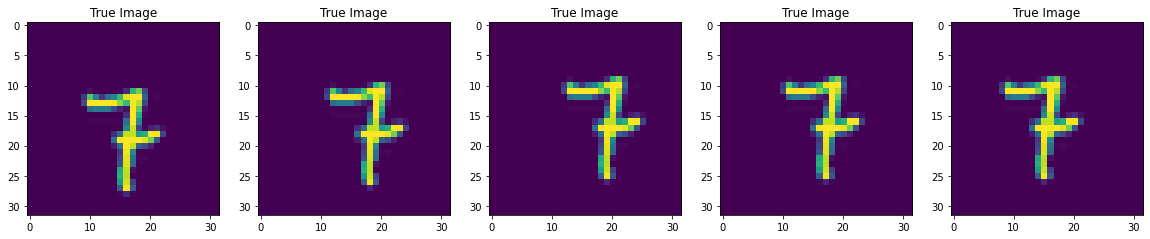

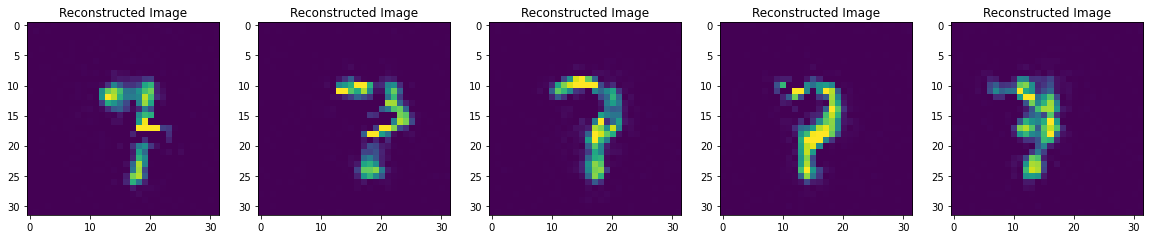

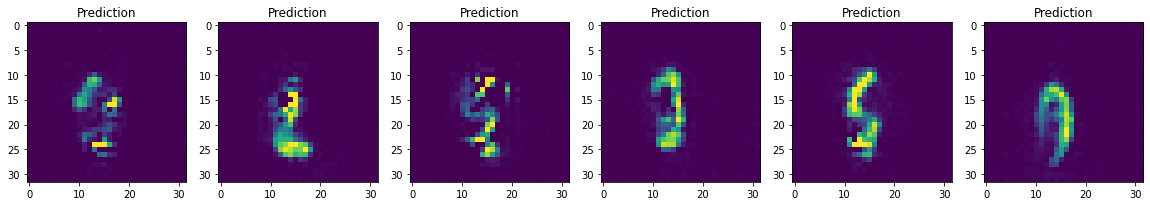

kl: tensor(0.3177, device='cuda:0') and tensor(7.1172, device='cuda:0')


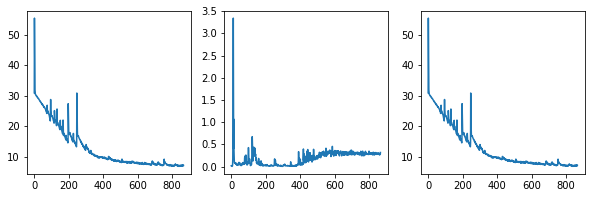

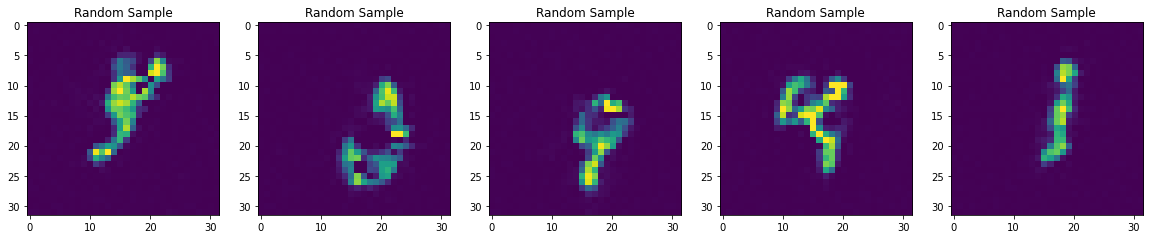

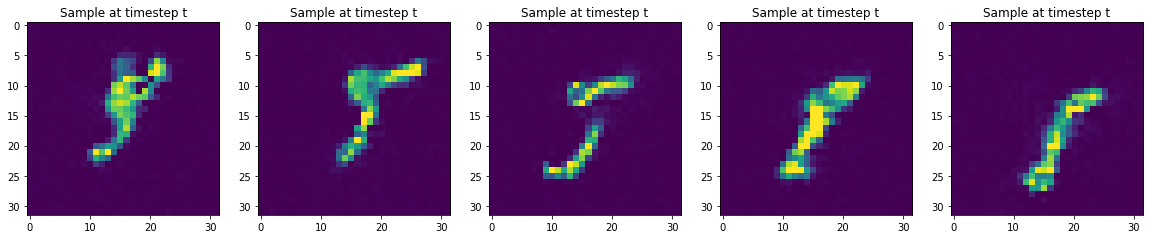

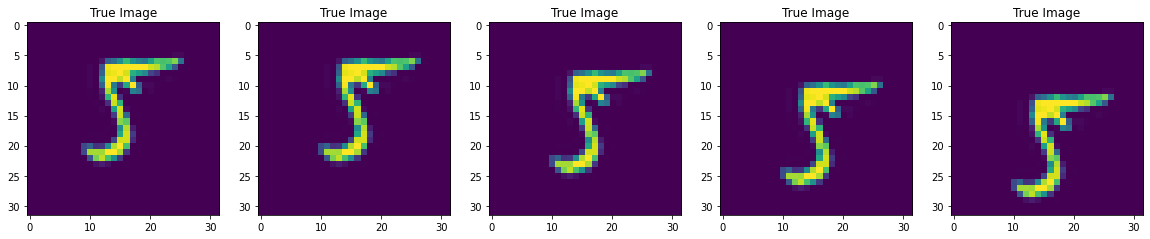

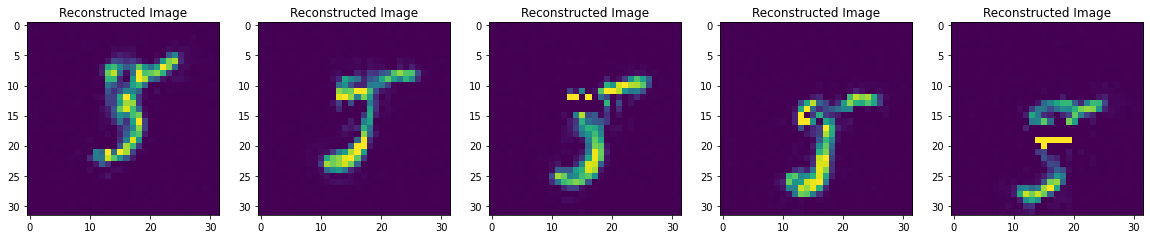

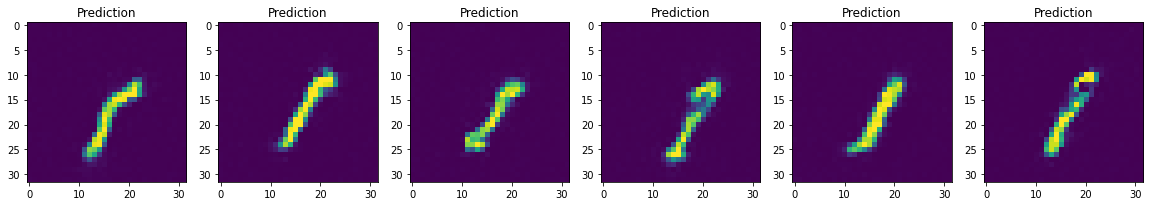

Epoch 2 Loss: 7.62


kl: tensor(0.2726, device='cuda:0') and tensor(6.4094, device='cuda:0')


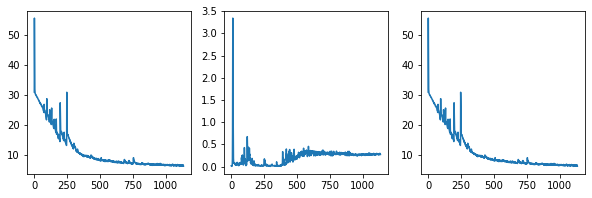

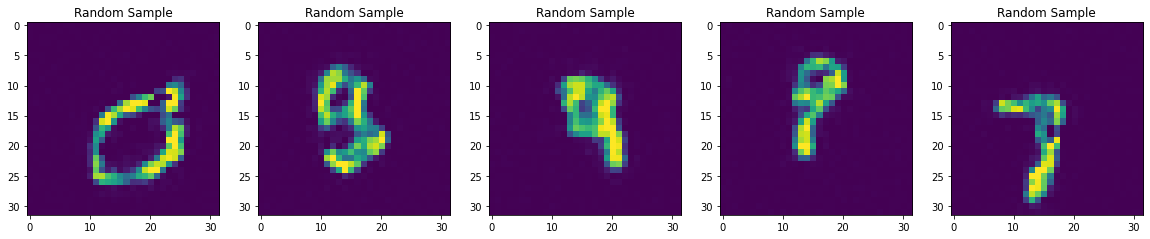

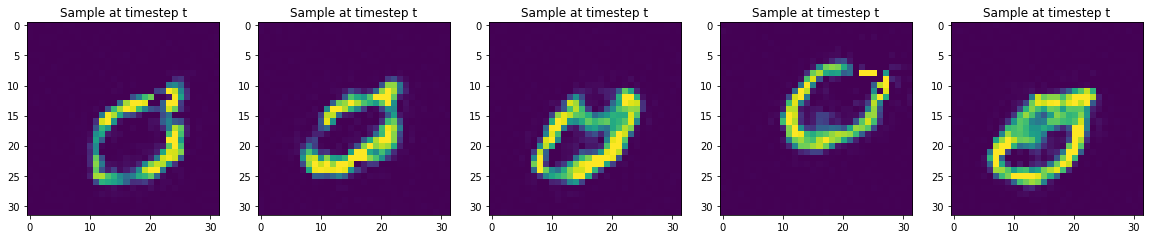

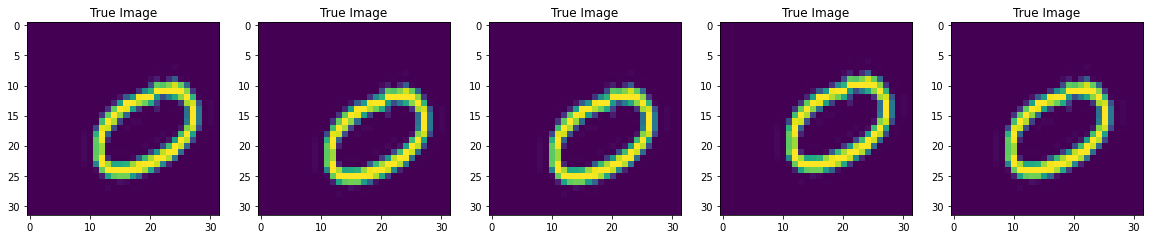

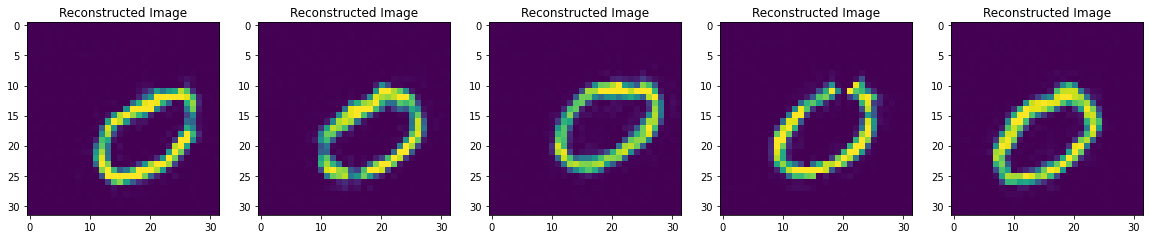

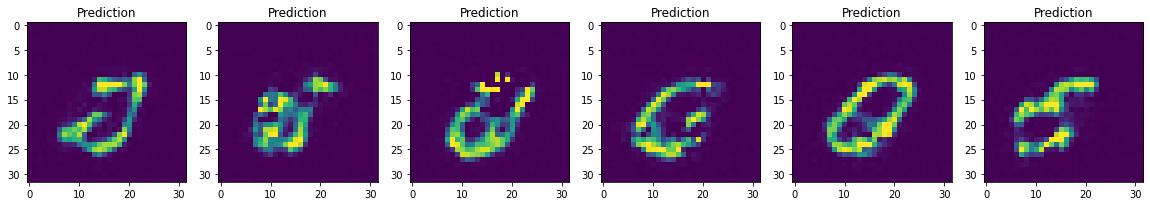

kl: tensor(0.2933, device='cuda:0') and tensor(6.2226, device='cuda:0')


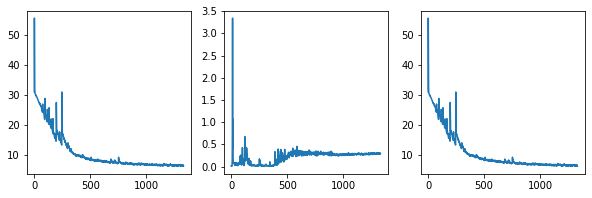

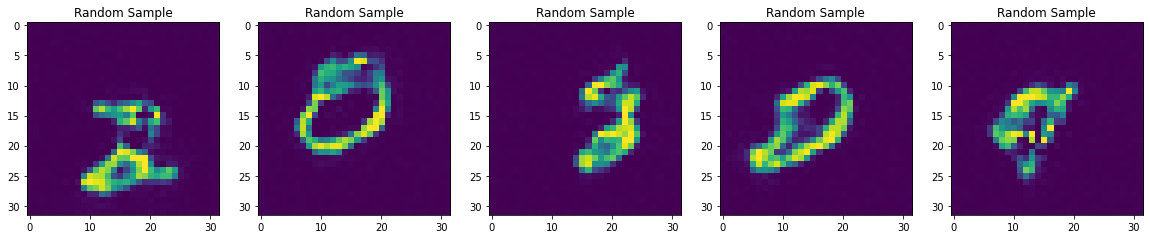

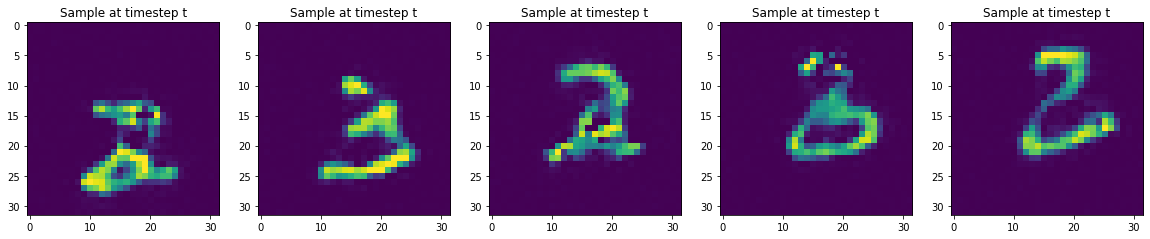

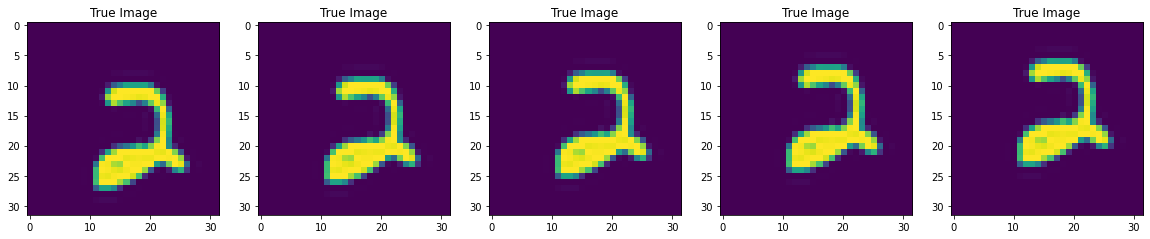

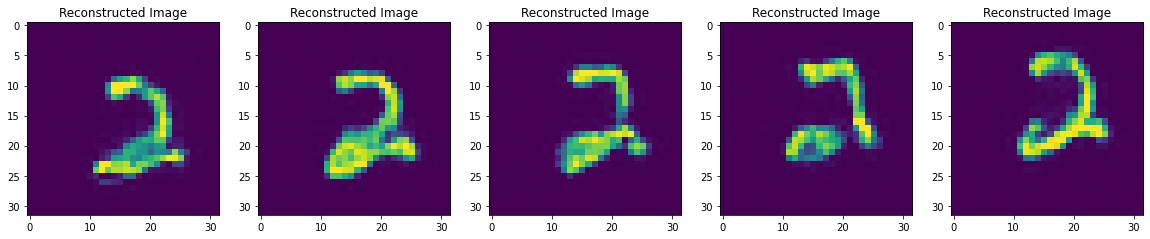

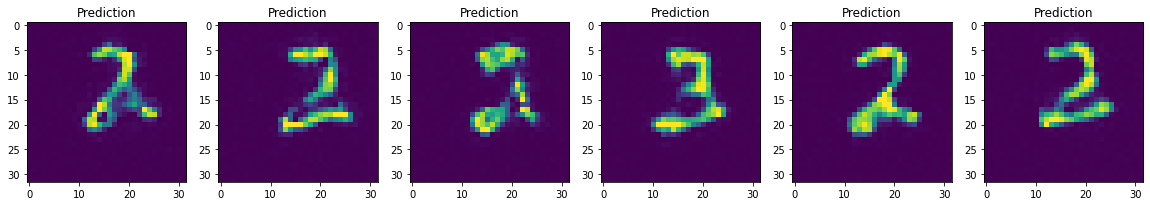

Epoch 3 Loss: 6.59


kl: tensor(0.3111, device='cuda:0') and tensor(6.2184, device='cuda:0')


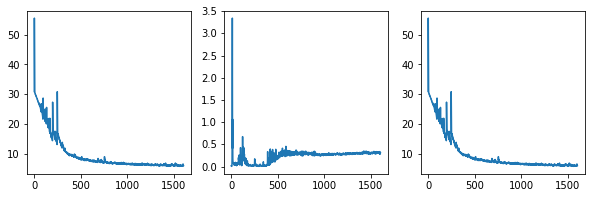

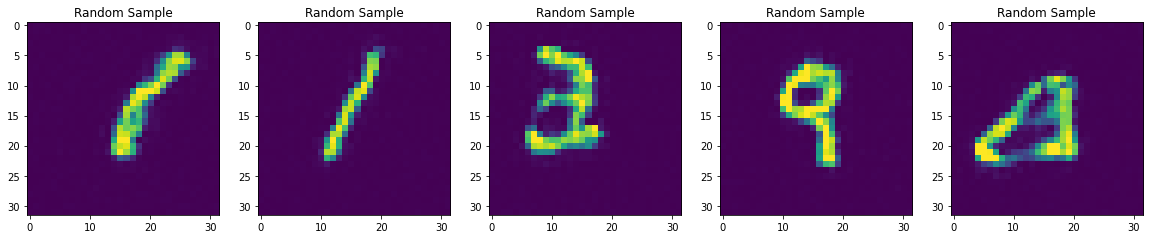

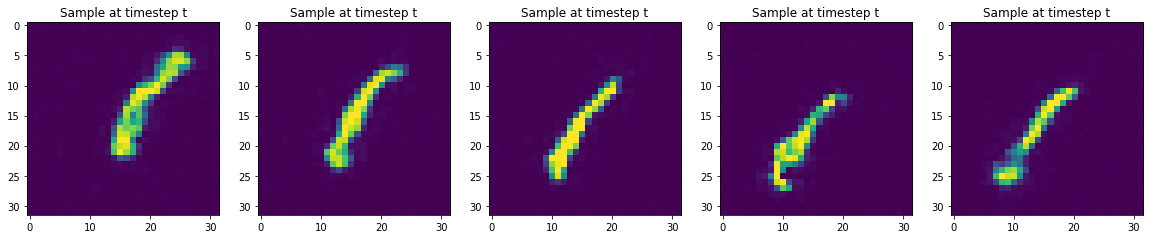

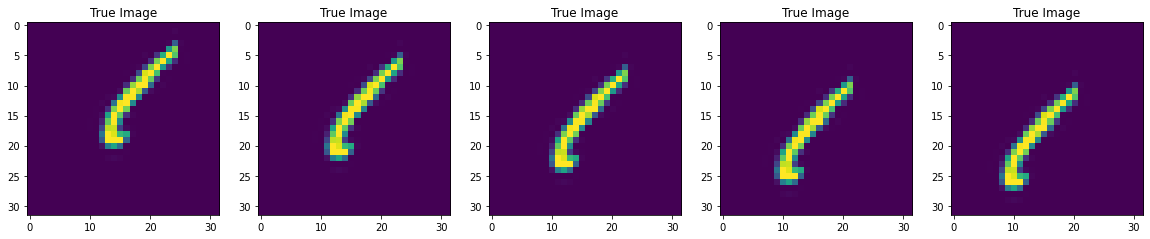

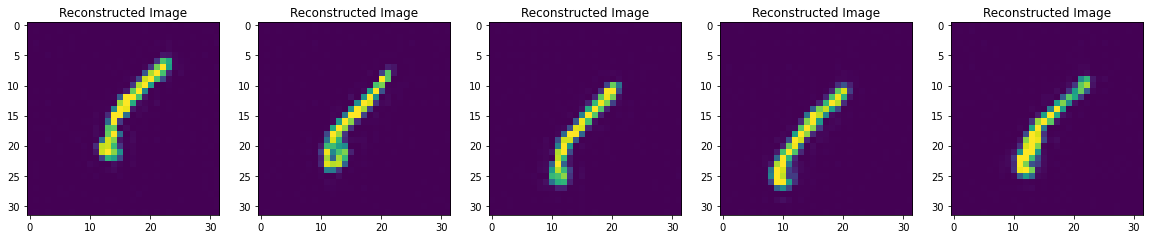

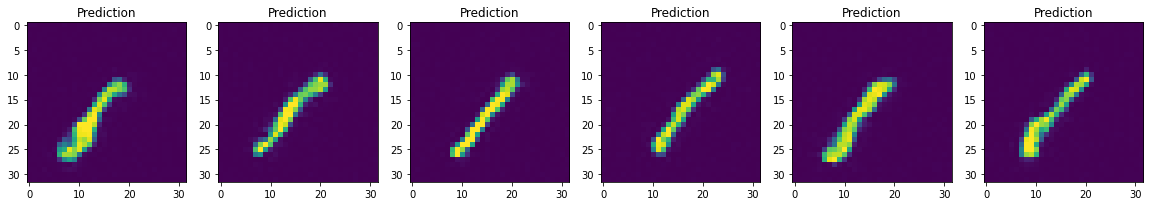

kl: tensor(0.3113, device='cuda:0') and tensor(5.8674, device='cuda:0')


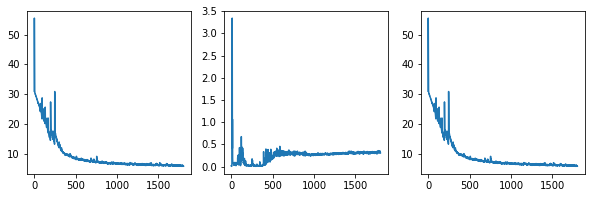

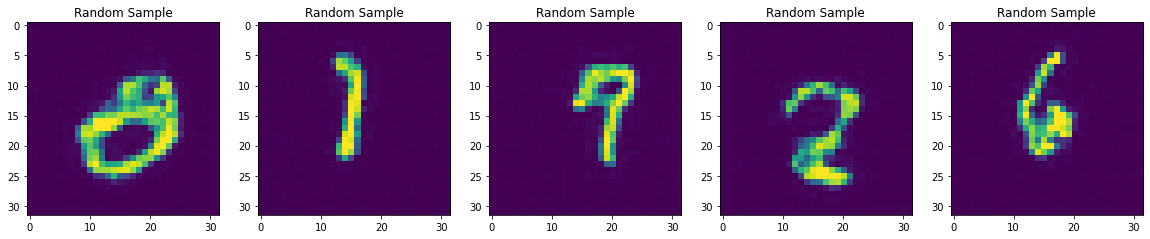

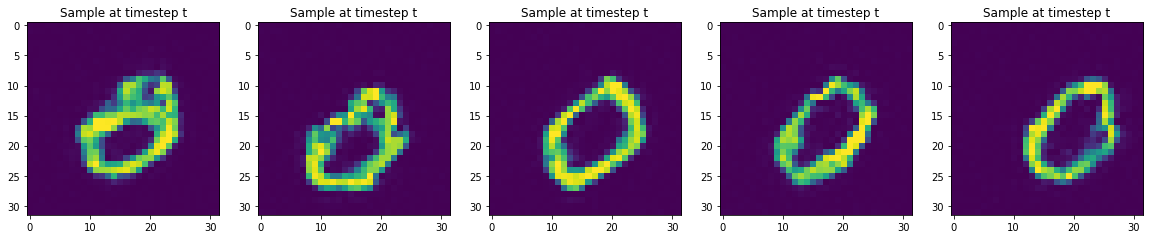

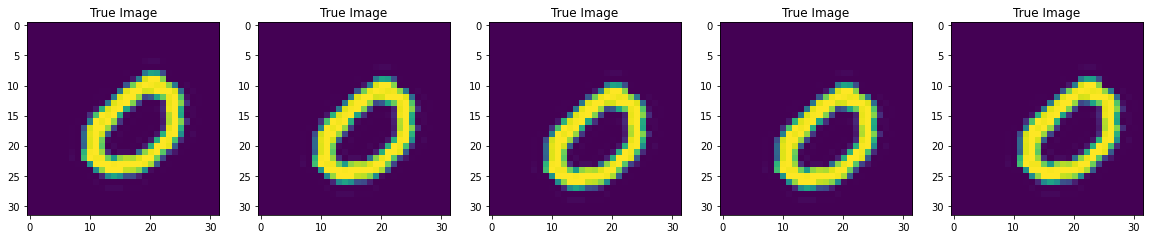

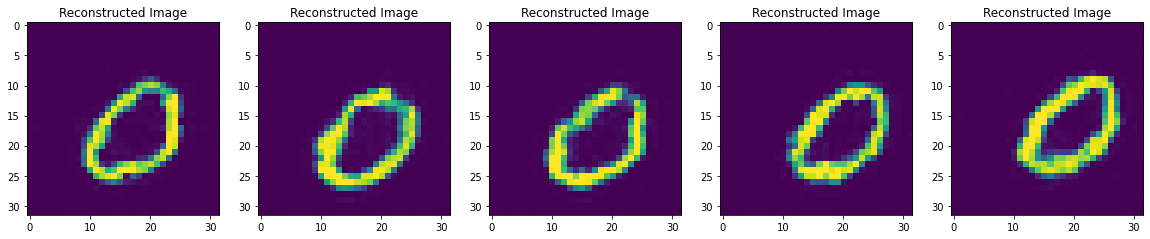

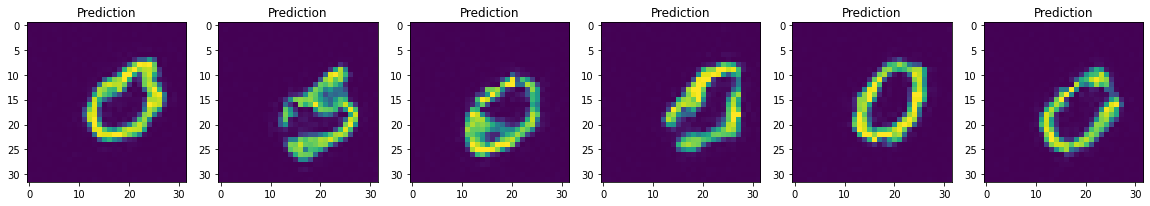

Epoch 4 Loss: 6.20


kl: tensor(0.3262, device='cuda:0') and tensor(5.9119, device='cuda:0')


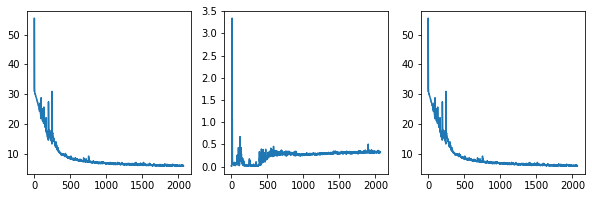

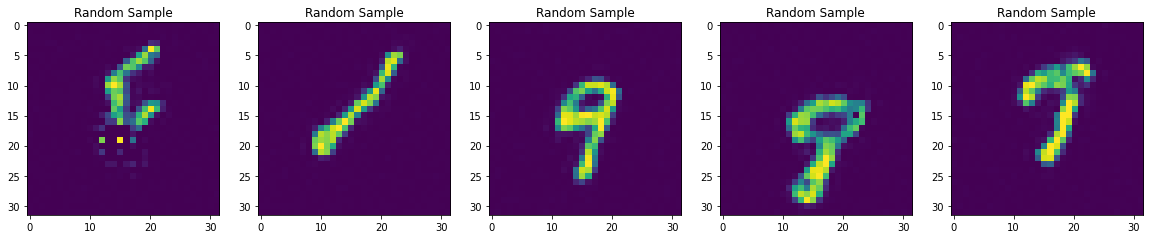

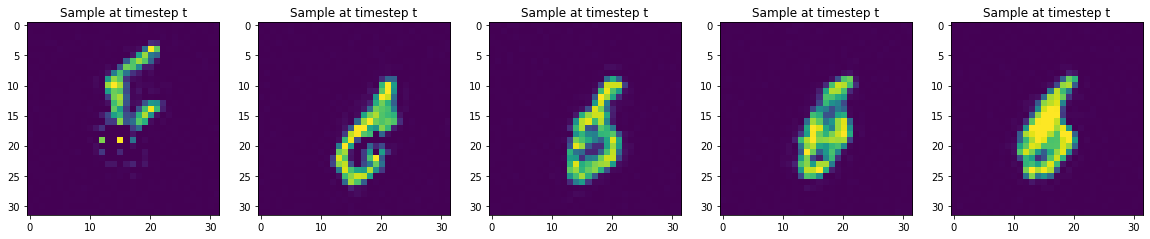

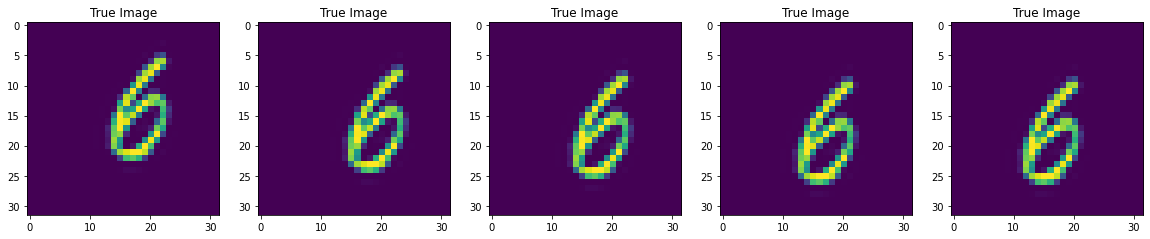

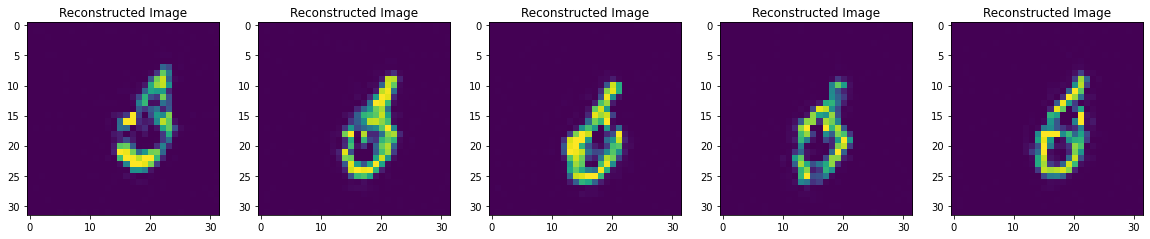

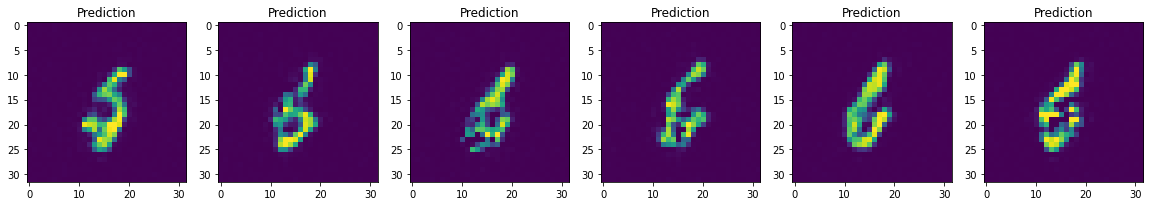

kl: tensor(0.3514, device='cuda:0') and tensor(5.7477, device='cuda:0')


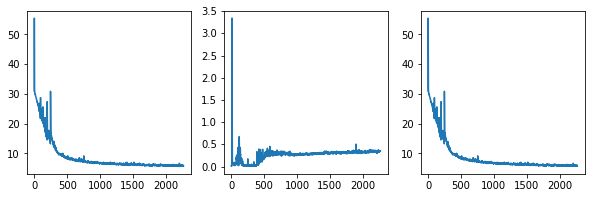

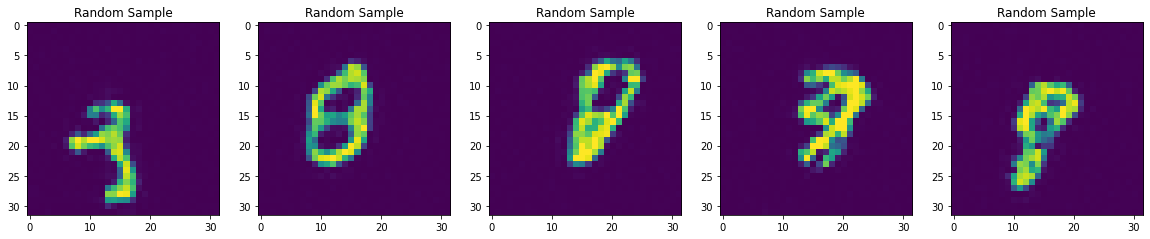

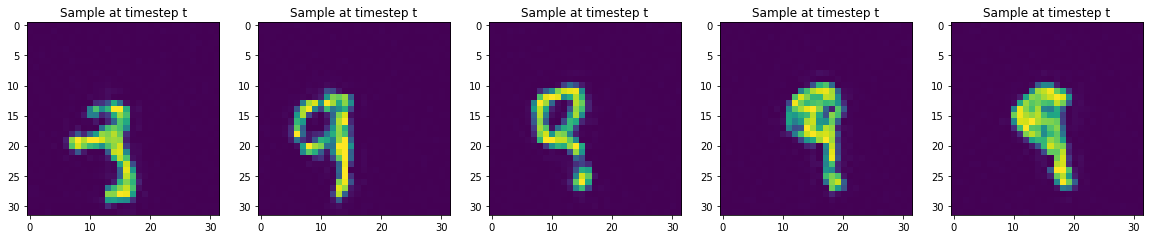

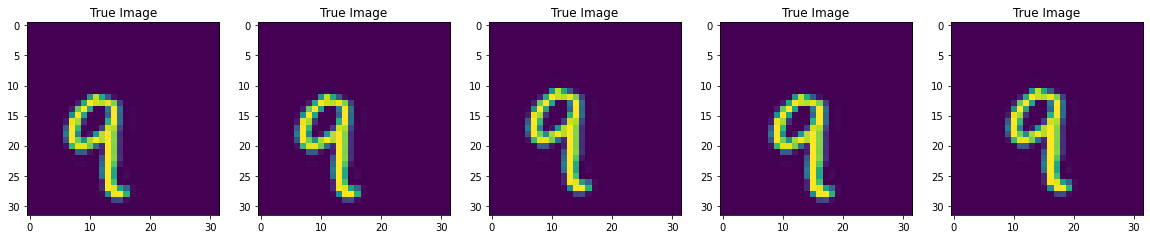

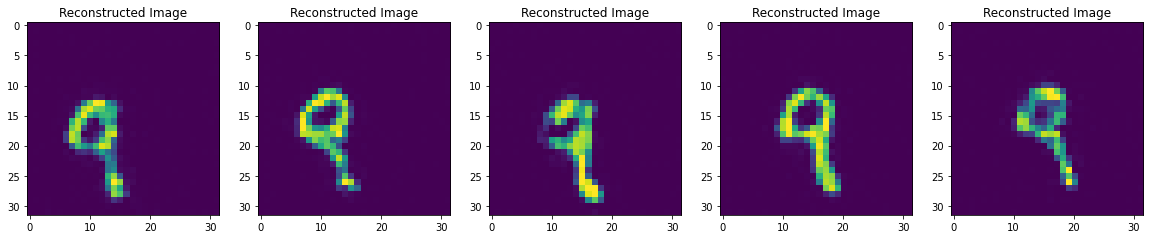

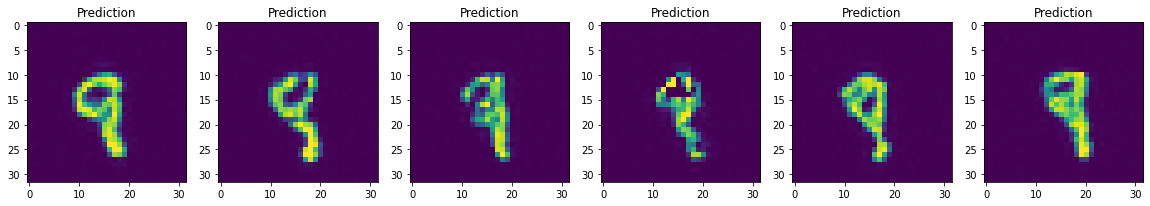

Epoch 5 Loss: 5.96


kl: tensor(0.3689, device='cuda:0') and tensor(5.6747, device='cuda:0')


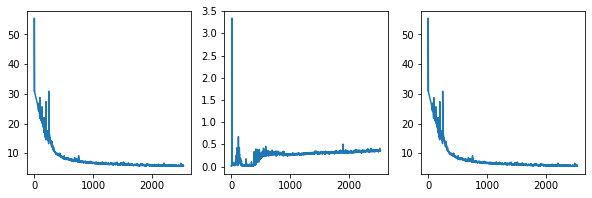

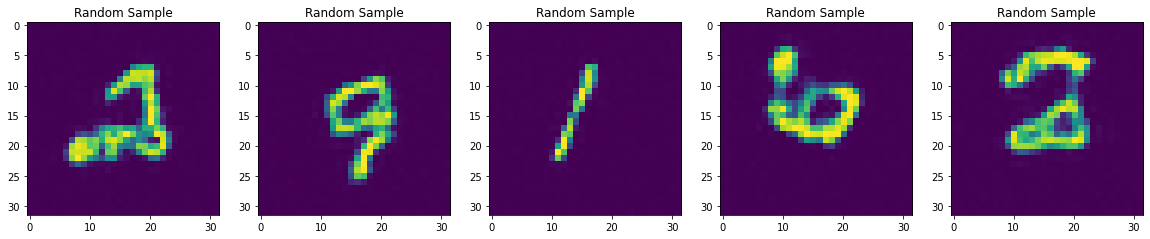

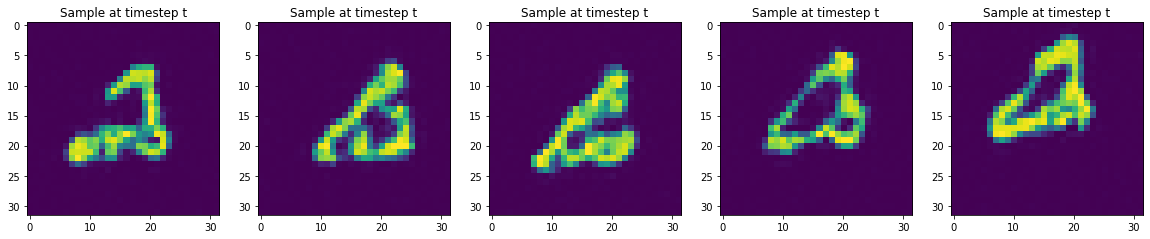

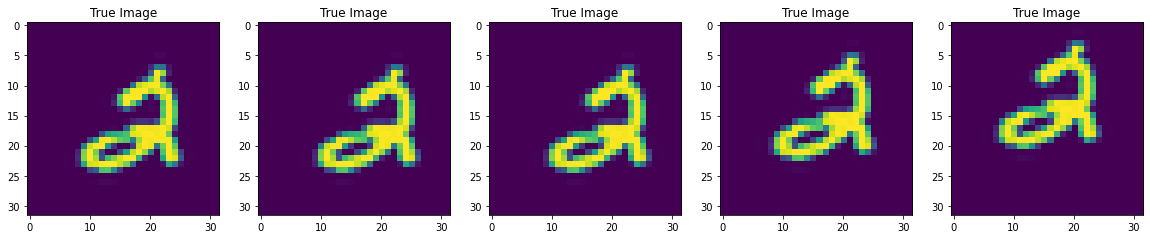

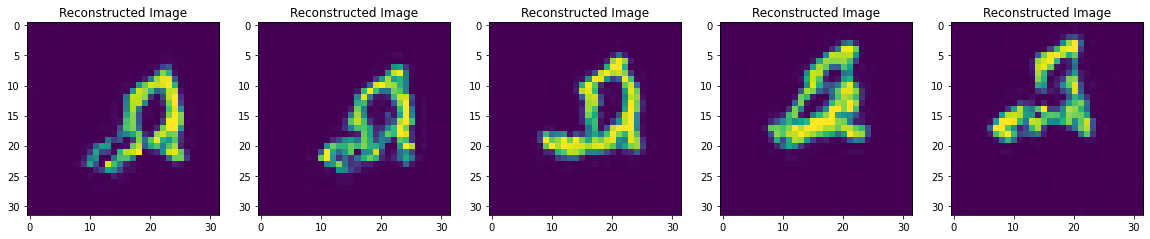

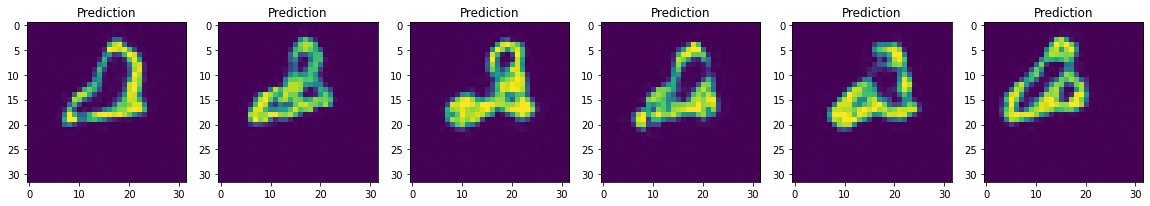

kl: tensor(0.3597, device='cuda:0') and tensor(5.6516, device='cuda:0')


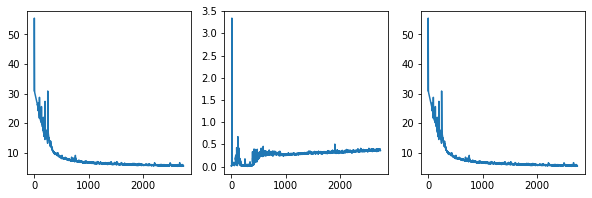

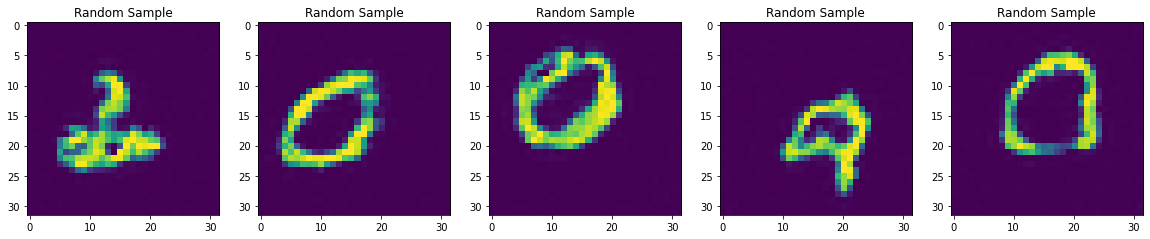

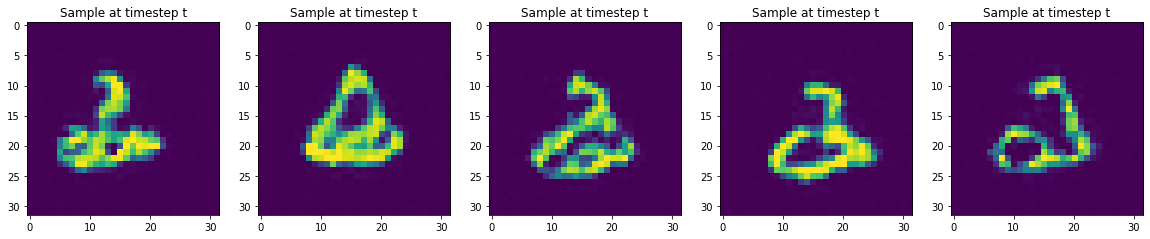

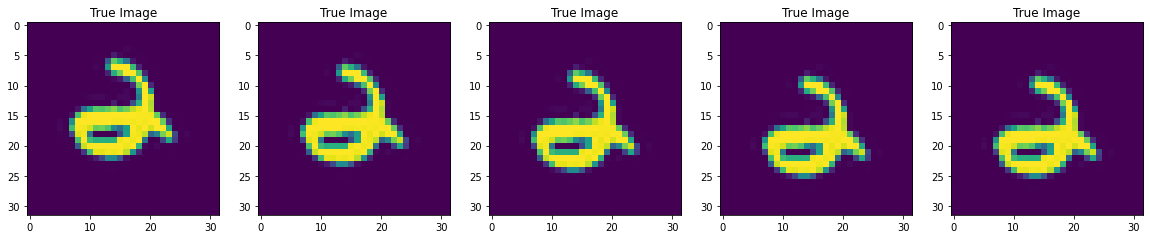

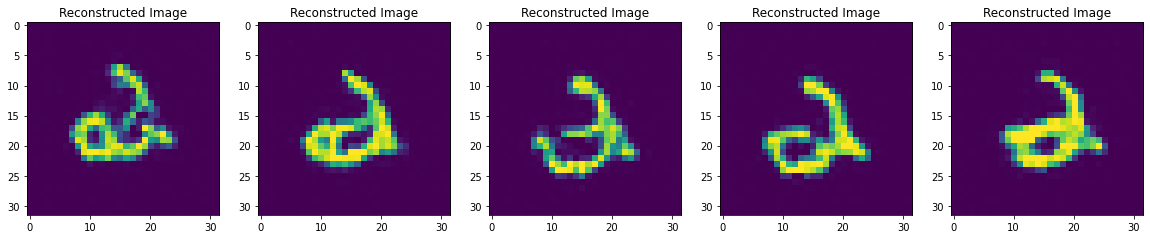

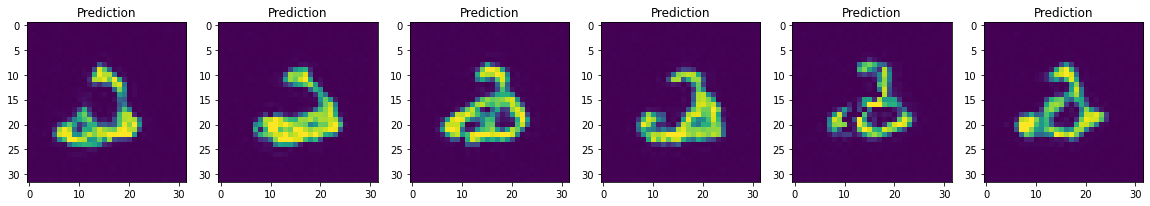

Epoch 6 Loss: 5.81


kl: tensor(0.3789, device='cuda:0') and tensor(5.4697, device='cuda:0')


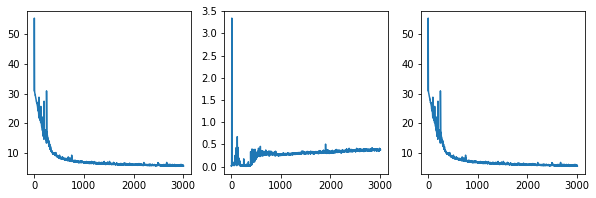

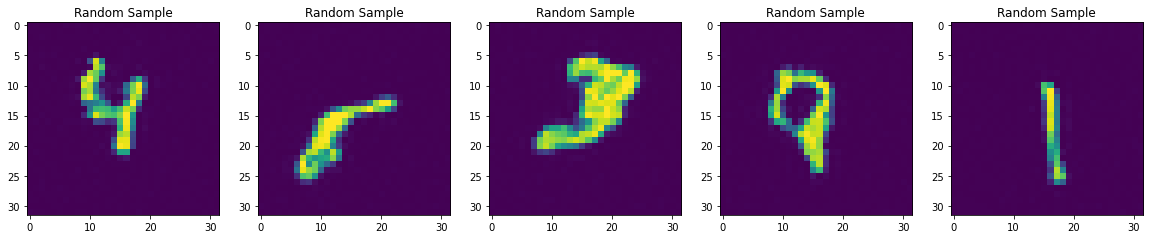

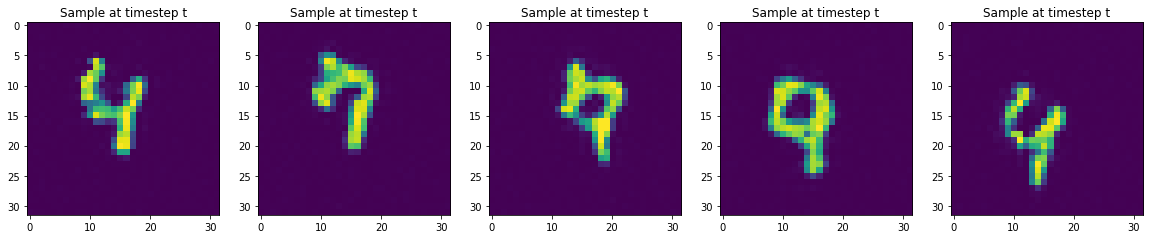

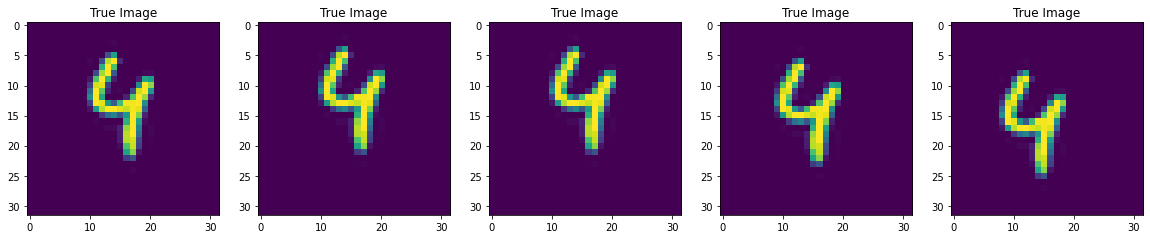

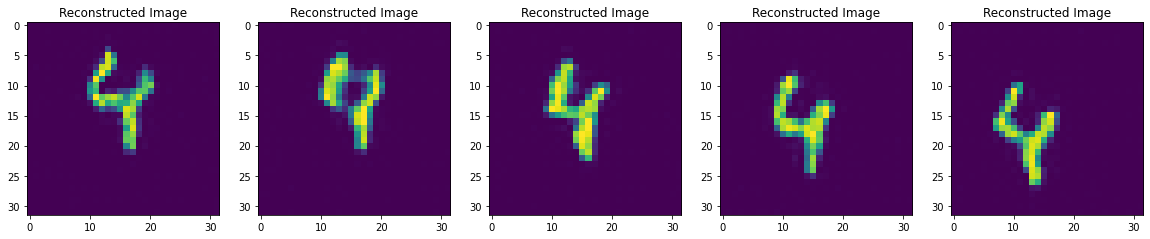

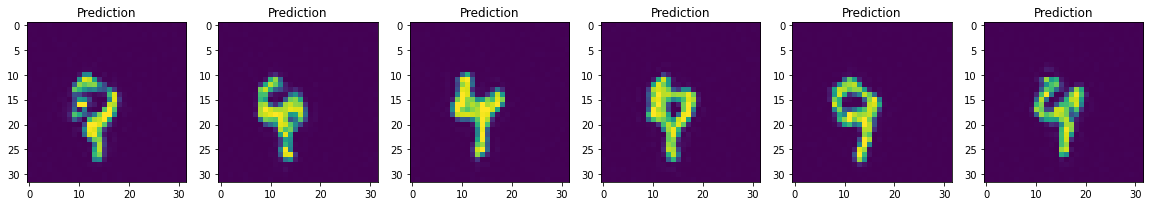

kl: tensor(0.3871, device='cuda:0') and tensor(5.6587, device='cuda:0')


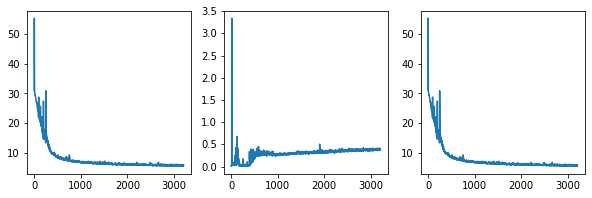

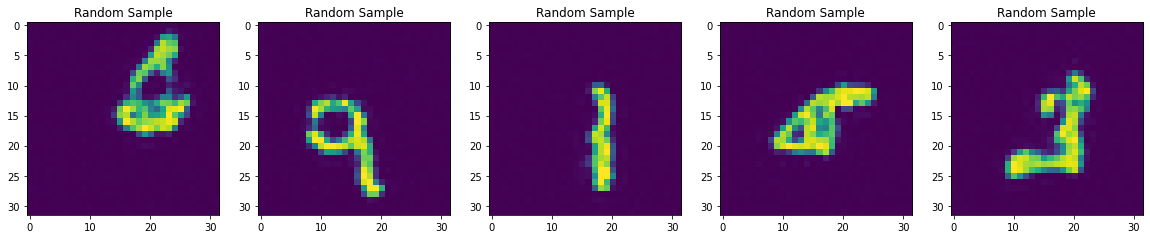

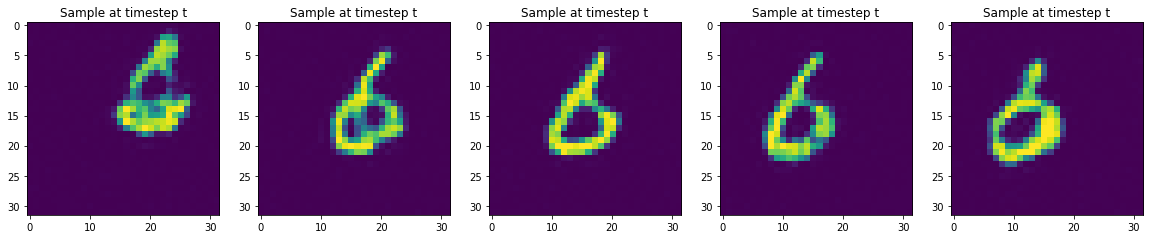

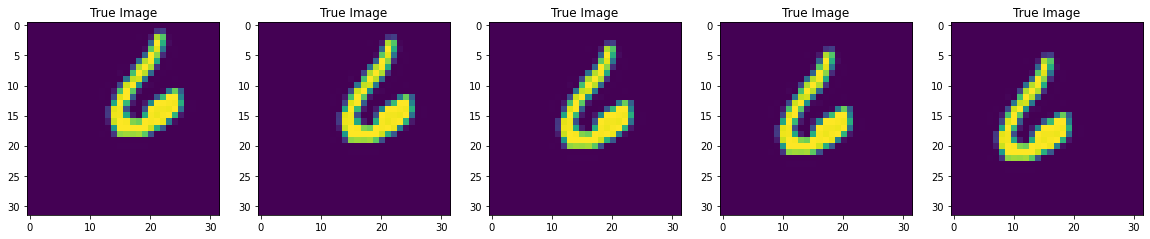

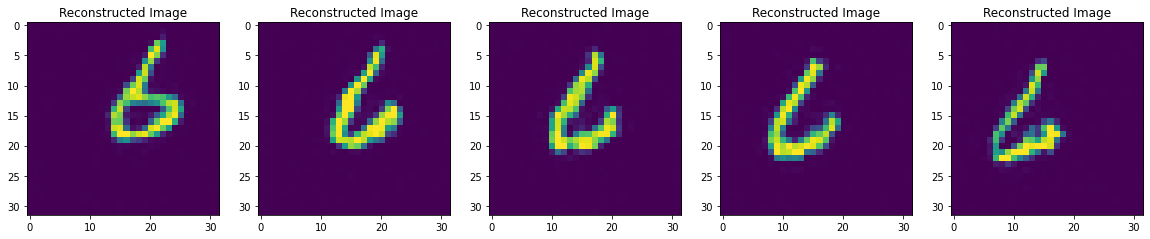

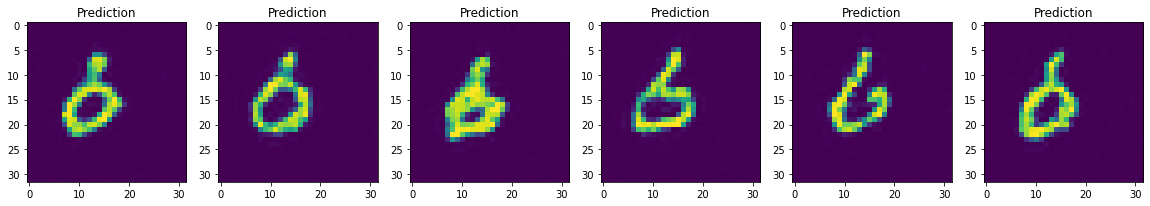

Epoch 7 Loss: 5.65


kl: tensor(0.4179, device='cuda:0') and tensor(5.7459, device='cuda:0')


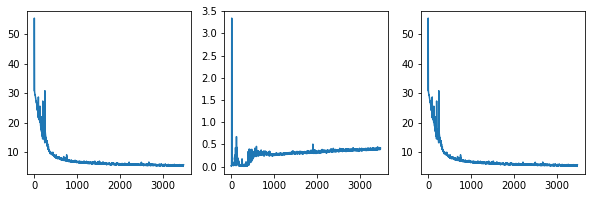

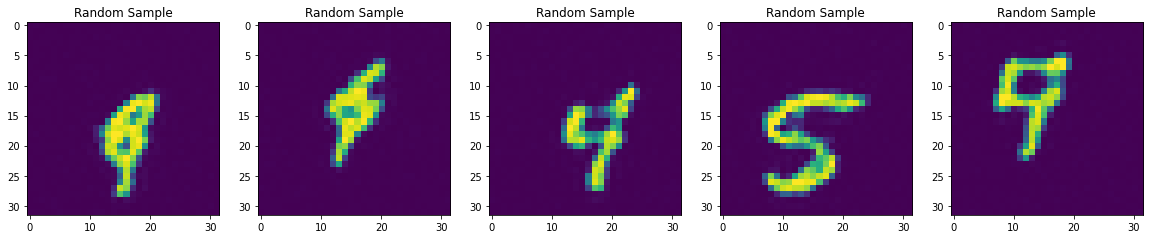

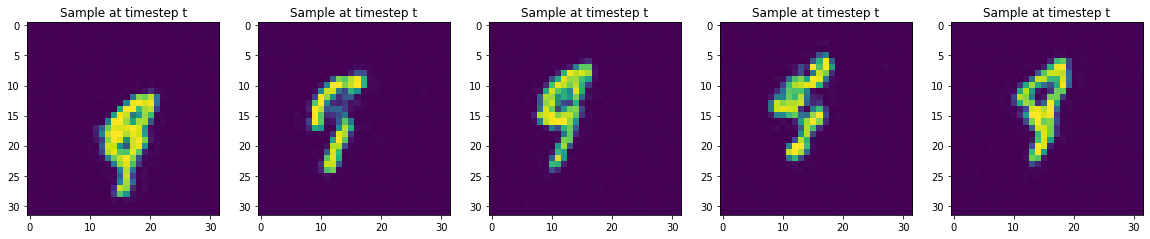

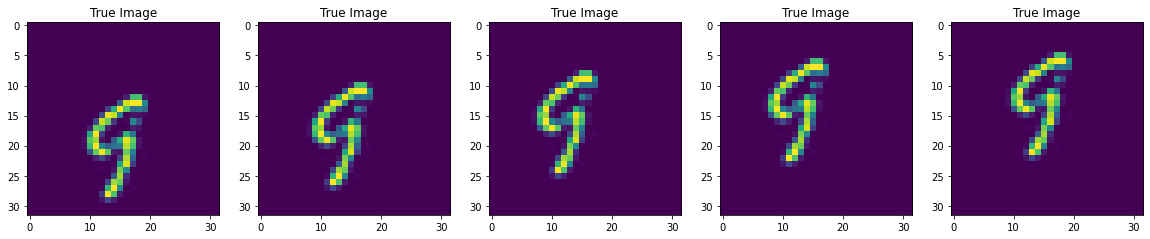

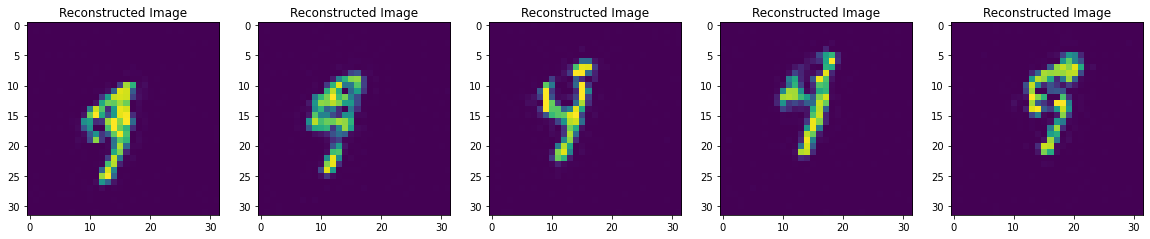

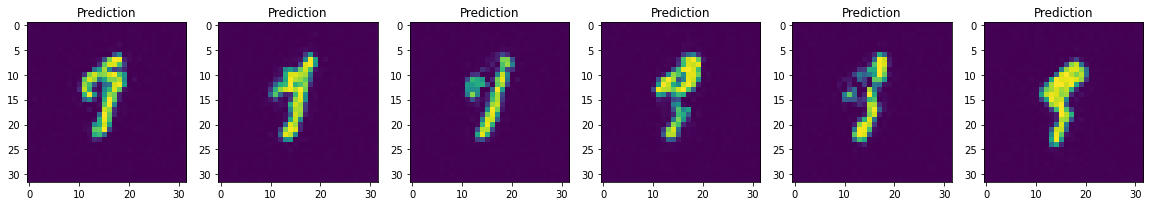

kl: tensor(0.3965, device='cuda:0') and tensor(5.4028, device='cuda:0')


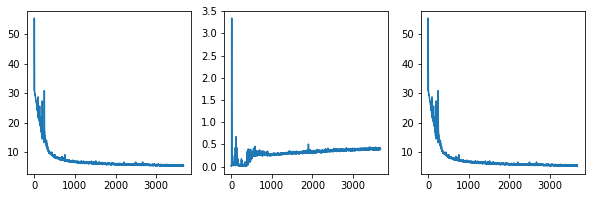

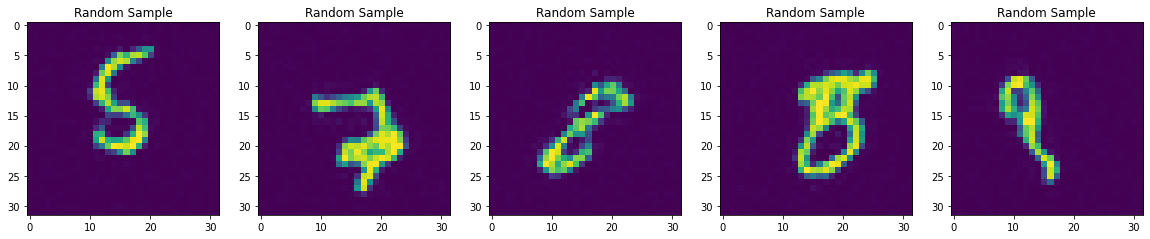

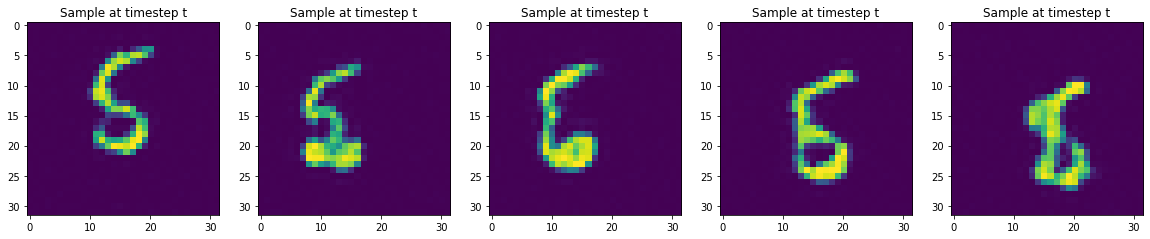

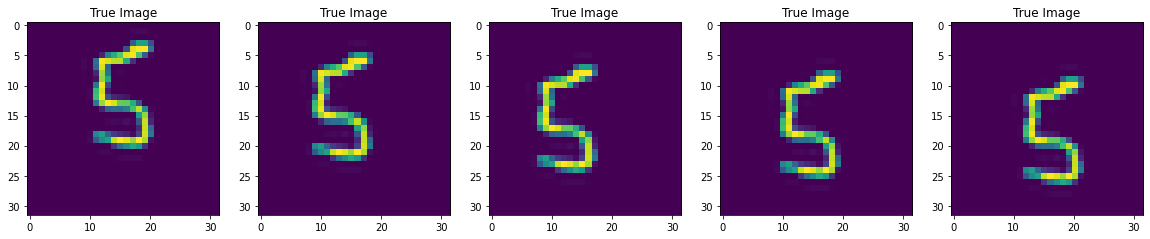

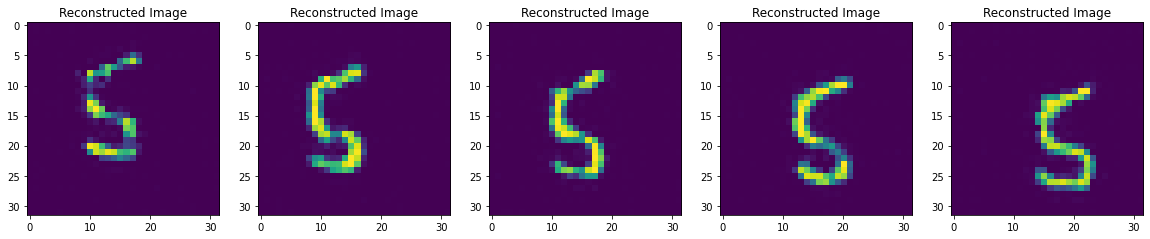

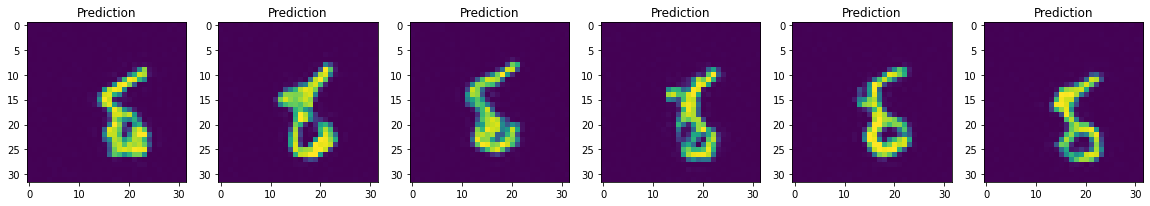

Epoch 8 Loss: 5.52


kl: tensor(0.4354, device='cuda:0') and tensor(5.3059, device='cuda:0')


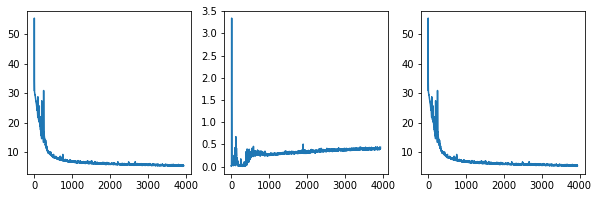

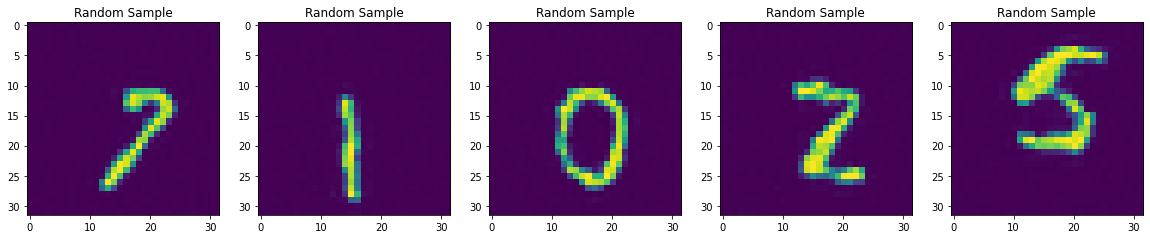

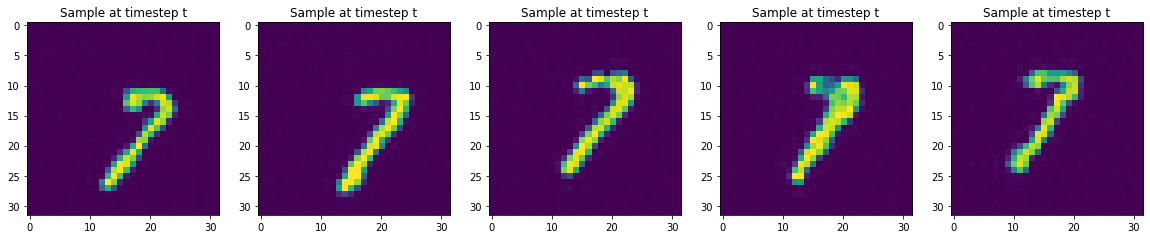

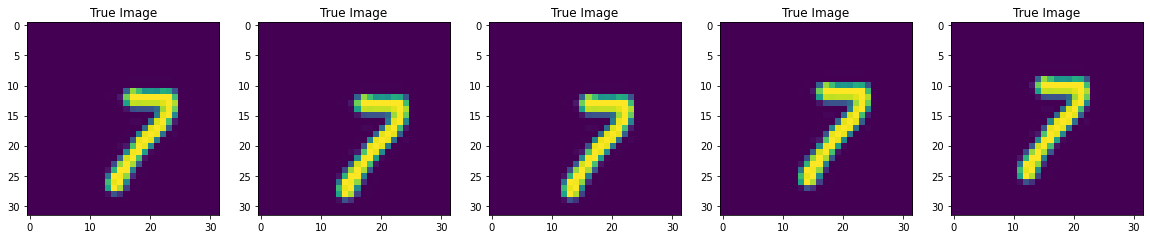

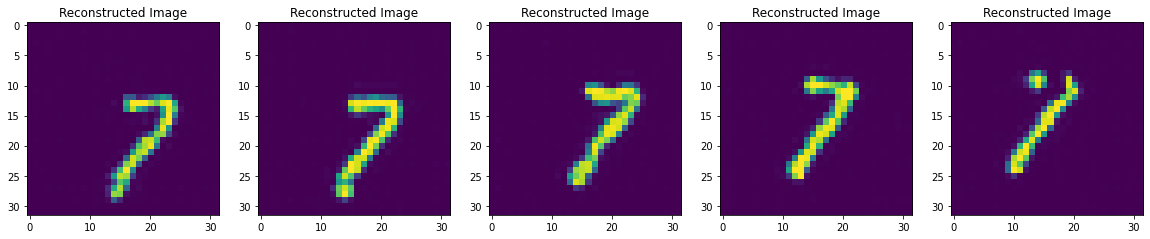

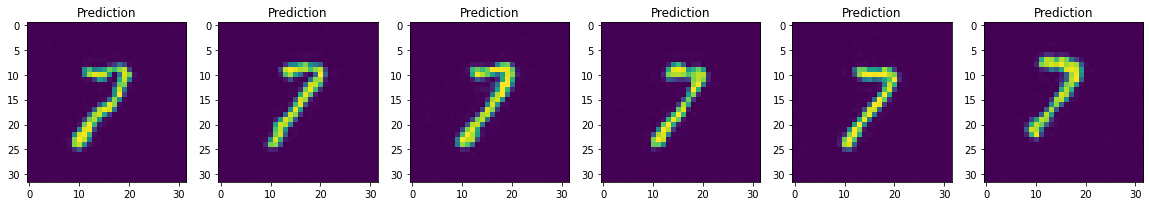

kl: tensor(0.4087, device='cuda:0') and tensor(5.3727, device='cuda:0')


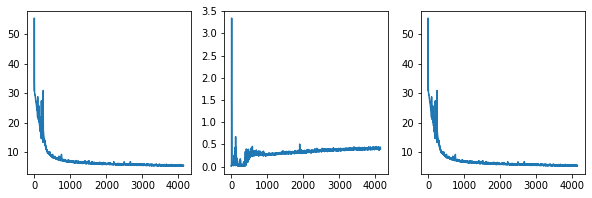

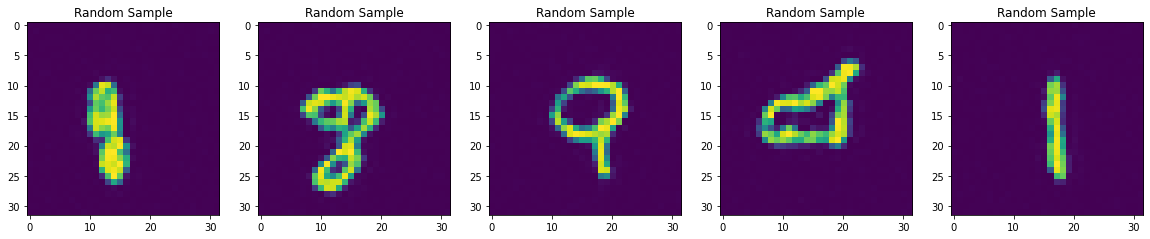

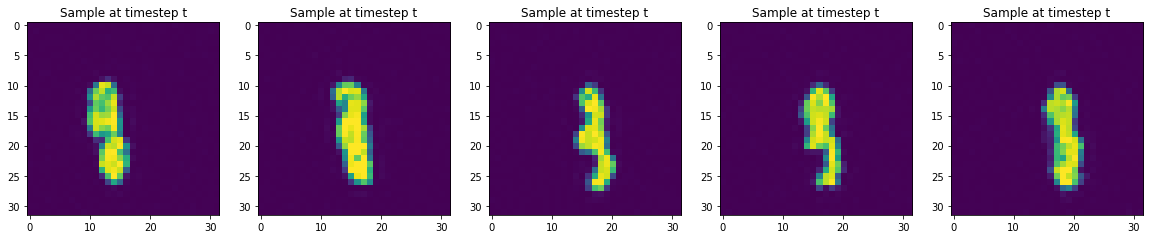

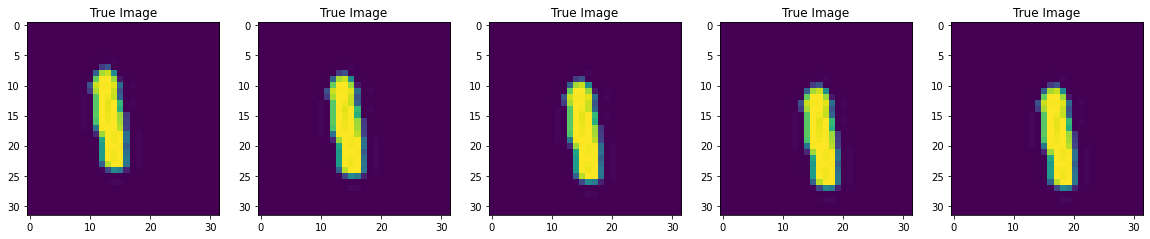

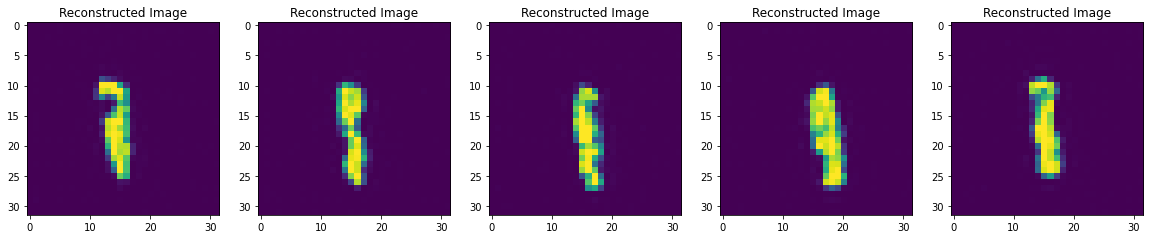

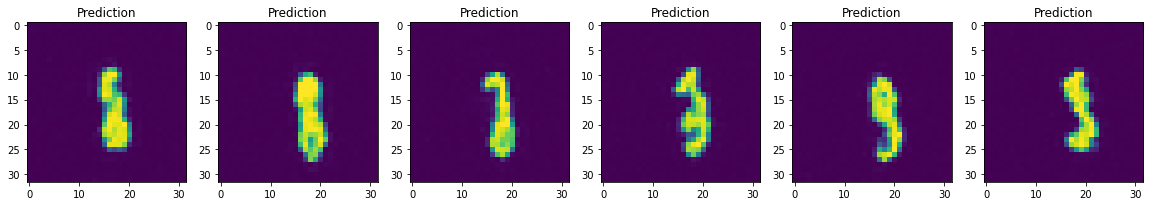

In [ ]:
n_bits = 7
class Solver(object):
    def __init__(self, learning_rate=0.0001, n_epochs=128):
        self.train_loader, self.test_loader = self.create_loaders()
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
        self.model = RFN().to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=4, factor = 0.5)

    def create_loaders(self):
        train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
        test_loader=DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last = True)
        return train_loader, test_loader
    
    def uniform_binning_correction(self, x, n_bits=8):
        b, t, c, h, w = x.size()
        n_bins = 2 ** n_bits
        chw = c * h * w
        x_noise = x + torch.zeros_like(x).uniform_(0, 1.0 / n_bins)
        objective = -np.log(n_bins) * chw * torch.ones(b, device=x.device)
        return x_noise, objective

    def preprocess(self, x, reverse=False, range="0.5", n_bits = 8):

        n_bins = 2 ** n_bits
        if range == "0.5":
          if reverse == False:
            x = x * 255 # scale to 255
            if n_bits < 8:
              x = torch.floor( x/2 ** (8 - n_bits))
            x = x / n_bins  - 0.5
          else:
            x = torch.clamp(x, -0.5, 0.5)
            x = x + 0.5
            x = x * n_bins
            x = torch.clamp(x * (255 / n_bins), 0, 255).byte()
        elif range == "1.0":
          if reverse == False:
            x = x * 255 # scale to 255
            if n_bits < 8:
              x = torch.floor( x/2 ** (8 - n_bits))
            x = x / n_bins  
          else:
            x = torch.clamp(x, 0, 1)
            x = x * n_bins
            x = torch.clamp(x * (255 / n_bins), 0, 255).byte()
        return x

    def train(self):
        self.losses = []
        train_losses = []
        val_losses = []
        self.kl_loss = []
        self.recon_loss = []
        
        # TODO: Scheduler
        counter = 0
        iterations = 2000

        for epoch_i in range(self.n_epochs):
            epoch_i += 1
            self.batch_loss_history = []
            for batch_i, image in enumerate(tqdm(self.train_loader, desc='Batch', leave=False)):
                image = image.to(device)

                image = self.preprocess(image, n_bits = n_bits)
                image, logdet = self.uniform_binning_correction(image, n_bits = n_bits)
                self.model.beta = min(0.01, 0.0001 + (counter+1)/iterations)
                loss = self.model.loss(image, logdet)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if (batch_i+1) % 200 == 0:
                  self.plotter()     
                self.batch_loss_history.append(float(loss.data))
                self.losses.append(loss.data)
                self.kl_loss.append(self.model.book['kl'])
                self.recon_loss.append(self.model.book['nll'])
                counter += 1
                
            epoch_loss = np.mean(self.batch_loss_history)
            self.scheduler.step(loss)
            print(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')
            train_losses.append(epoch_loss)
        return train_losses

    def plotter(self):
      fig, ax = plt.subplots(1, 3 , figsize = (10,3))
      ax[0].plot(self.losses)
      ax[1].plot(self.kl_loss)
      ax[2].plot(self.recon_loss)
      print("kl: {} and {}".format(str(self.kl_loss[-1]), str(self.recon_loss[-1])))
      with torch.no_grad():
        self.model.eval()
        image = next(iter(self.test_loader)).to(device)
        time_steps = 5
        n_predictions = 6
        image  = self.preprocess(image, reverse=False, n_bits = n_bits)
        #image, _ = self.uniform_binning_correction(image, n_bits = n_bits)
        samples, samples_recon, predictions = self.model.sample(image, n_predictions = n_predictions)
        samples  = self.preprocess(samples, reverse=True, n_bits = n_bits)
        samples_recon  = self.preprocess(samples_recon, reverse=True, n_bits = n_bits)
        predictions  = self.preprocess(predictions, reverse=True, n_bits = n_bits)
        image  = self.preprocess(image, reverse=True, n_bits = n_bits)
        self.model.train()

      fig, ax = plt.subplots(1, 5 , figsize = (20,5))
      for i in range(0, 5):
        ax[i].imshow(samples[0, i, :, :, :].view(-1, 32).detach().cpu().numpy())
        ax[i].set_title("Random Sample")

      fig, ax = plt.subplots(1, time_steps , figsize = (20,5))
      for i in range(0, time_steps):
        ax[i].imshow(samples[i, 0, :, :, :].view(-1, 32).detach().cpu().numpy())
        ax[i].set_title("Sample at timestep t")
      
      fig, ax = plt.subplots(1, time_steps , figsize = (20,5))
      for i in range(0, time_steps):
        ax[i].imshow(image[0, i, :, :, :].view(-1, 32).detach().cpu().numpy())
        ax[i].set_title("True Image")

      fig, ax = plt.subplots(1, time_steps , figsize = (20,5))
      for i in range(0, time_steps):
        ax[i].imshow(samples_recon[i, 0, :, :, :].view(-1, 32).detach().cpu().numpy())
        ax[i].set_title("Reconstructed Image")

      fig, ax = plt.subplots(1, n_predictions , figsize = (20,5))
      for i in range(0, n_predictions):
        ax[i].imshow(predictions[i, 0, :, :, :].view(-1, 32).detach().cpu().numpy())
        ax[i].set_title("Prediction")
      plt.show()


solver = Solver(n_epochs=60, learning_rate=0.001)
solver.build()
train = solver.train()


In [ ]:
# FOR USING PRETRAINED MODEL

class PassOn(nn.Module):
  def __init__(self):
    super(PassOn, self).__init__()

  def forward(self, x):
    return x.view(128, 512, 2, 2)

resnet18 = torchvision.models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)
resnet18.avgpool = nn.ReLU()
resnet18.fc = PassOn()
# Resnet test
#resnet18(test).shape



## Test script for list glow

In [ ]:

L=3
x = torch.zeros(32,1,32,32).to(device)
structure = [32, 32, 'conv', 64, 64, 'conv', 128, 128, 'conv', 256]
ext = VGG_downscaler(structure).to(device)
out = ext(x)
structure2 = [[256, 256, 'deconv', 128], [128, 'deconv', 64], [64, 'deconv', 1]]
ups= VGG_upscaler(structure2, L=3, in_channels = 256).to(device)
final, out2 = ups(out)
condition_size = [(32,64,16,16), (32,128,8,8), (32,256,4,4)]
base_dist_size = (32,256,4,4)

test_glow = ListGlow((32,1,32,32), condition_size, base_dist_size, K=3, L=L, learn_prior = True).to(device)
z,nll = test_glow.log_prob(x, out2, out2[-1], 0.0)
test_glow.sample(z=None, condition=out2, base_condition=out2[-1]).shape



# Test script for VGG models

In [ ]:
L=3
x = torch.zeros(32,1,32,32).to(device)
structure = [32, 32, 'conv', 64, 64, 'conv', 128, 128, 'conv', 256]
ext = VGG_downscaler(structure).to(device)
out = ext(x)
structure2 = [[256, 256, 'deconv', 128], [128, 'deconv', 64], [64, 'deconv', 1]]
ups= VGG_upscaler(structure2, L=3, in_channels = 256).to(device)

final, out2 = ups(out)


out2[0].shape
final.shape

L=3
x = torch.zeros(32,1,32,32).to(device)
structure = [32, 32, 'conv', 64, 'conv', 128, 'conv', 256]
ext = VGG_downscaler(structure).to(device)
out = ext(x)
structure2 = [[256, 256, 'deconv', 128], ['deconv', 64], ['deconv', 32]]
ups= VGG_upscaler(structure2, L=3, in_channels = 256).to(device)
final, out2 = ups(out)
out2[0].shape

# Test script for RFN

In [ ]:
test = RFN().to(device)
x = torch.zeros(batch_size,4,1,32,32).to(device)
test.loss(x, 0.0)
ss, sr, pr = test.sample(x)